In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from PIL import ImageColor

In [2]:
def load_image(image_num):
    # Load the image
    image_path = '../plot_images/'+ str(image_num) +'.png'
    image = cv2.imread(image_path)
    return image

In [3]:
image = load_image(15)

In [4]:
def get_color_masks(image):
    # Convert the original image from BGR to HSV for better color segmentation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Blue color range (e.g., for the blue data series)
    blue_lower = np.array([100, 50, 50])
    blue_upper = np.array([140, 255, 255])

    # Red color range (e.g., for the red data series)
    # Red has two ranges because it wraps around the hue axis
    red_lower1 = np.array([0, 50, 50])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 50, 50])
    red_upper2 = np.array([180, 255, 255])

    # Other colors would follow a similar pattern

    # Threshold the HSV image to get only blue colors
    blue_mask = cv2.inRange(hsv_image, blue_lower, blue_upper)

    # Threshold the HSV image to get only red colors
    red_mask1 = cv2.inRange(hsv_image, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv_image, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # Combine masks for all series for demonstration
    combined_mask = cv2.bitwise_or(blue_mask, red_mask)

    # Bitwise-AND mask and original image
    isolated_blue = cv2.bitwise_and(image, image, mask=blue_mask)
    isolated_red = cv2.bitwise_and(image, image, mask=red_mask)
    isolated_combined = cv2.bitwise_and(image, image, mask=combined_mask)

    # Convert back to RGB for display with matplotlib
    isolated_blue_rgb = cv2.cvtColor(isolated_blue, cv2.COLOR_BGR2RGB)
    isolated_red_rgb = cv2.cvtColor(isolated_red, cv2.COLOR_BGR2RGB)
    isolated_combined_rgb = cv2.cvtColor(isolated_combined, cv2.COLOR_BGR2RGB)

    return isolated_blue_rgb, isolated_red_rgb, isolated_combined_rgb

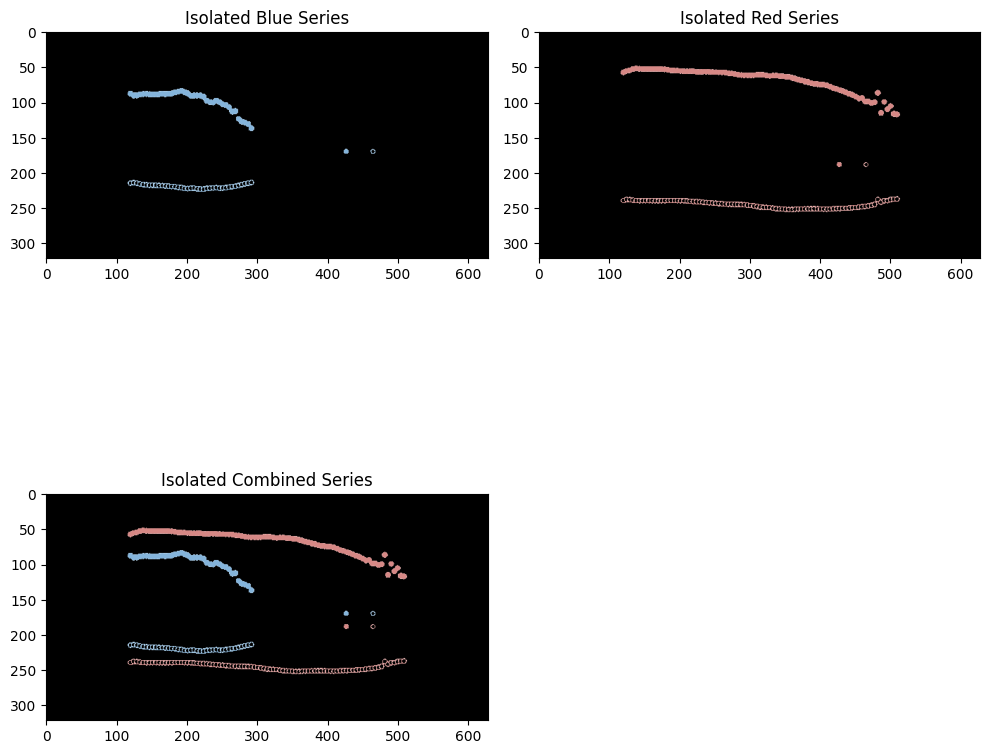

In [5]:
isolated_blue_rgb, isolated_red_rgb, isolated_combined_rgb = get_color_masks(image)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(isolated_blue_rgb)
plt.title('Isolated Blue Series')

plt.subplot(2, 2, 2)
plt.imshow(isolated_red_rgb)
plt.title('Isolated Red Series')

plt.subplot(2, 2, 3)
plt.imshow(isolated_combined_rgb)
plt.title('Isolated Combined Series')

plt.tight_layout()
plt.show()

In [6]:
def get_gray_series(isolated_combined_rgb):
    # Convert the isolated gray series to grayscale
    gray_series_gray = cv2.cvtColor(isolated_combined_rgb, cv2.COLOR_BGR2GRAY)

    # Apply a binary threshold to get a binary image
    _, binary_series = cv2.threshold(gray_series_gray, 1, 255, cv2.THRESH_BINARY)

    # Perform morphological closing to connect close components (fill gaps)
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(binary_series, cv2.MORPH_CLOSE, kernel)

    # Find contours on the closed image
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the top series has larger areas, sort contours by area and take the largest two
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:6]
    return binary_series, sorted_contours

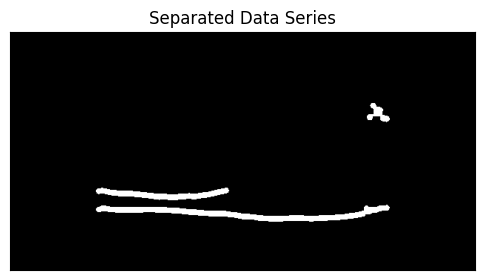

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

binary_series, sorted_contours = get_gray_series(isolated_combined_rgb)

# Create an empty mask to draw the separated contours
separated_mask = np.zeros_like(binary_series)

# Define a list of colors, each color is in BGR format
colors = [
    (255, 0, 0),   # Blue
    (0, 255, 0),   # Green
    (0, 0, 255),   # Red
    (255, 255, 0), # Cyan
    (255, 0, 255), # Magenta
    (0, 255, 255), # Yellow
    # ... add more colors as needed, or generate them randomly
]

# Draw the contours on the mask
for index, sorted_c in enumerate(sorted_contours):
    # Cycle through the list of colors
    color = colors[index % len(colors)]
    cv2.drawContours(separated_mask, [sorted_c], -1, color, -1)  # Draw contour with unique color

# Convert from BGR to RGB for displaying with matplotlib
separated_mask_rgb = cv2.cvtColor(separated_mask, cv2.COLOR_BGR2RGB)

# Show the separated contours
plt.figure(figsize=(6, 6))
plt.imshow(separated_mask_rgb)
plt.title('Separated Data Series')
plt.xticks([]), plt.yticks([])  # Hide tick marks
plt.show()


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import json
import numpy as np
import cv2
import boto3
from utils import *
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from roboflow import Roboflow
from segment_anything import SamPredictor, sam_model_registry

In [9]:
from helper_code.full_extraction_pipeline import get_reconstructed_plot, is_valid_color

In [10]:
rf = Roboflow(ROBOFLOW_API_KEY)
project = rf.workspace().project("legend_classified")
model = project.version(5).model

loading Roboflow workspace...
loading Roboflow project...


In [11]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

In [12]:
import colorsys
# Function to adjust the lightness of a color
def adjust_lightness(color, factor):
    # Convert named color to RGB
    r, g, b = to_rgb(color)
    # Convert RGB to HLS
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    # Adjust lightness
    l = max(min(l * factor, 1), 0)
    # Convert back to RGB
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return r, g, b

In [13]:
def plot_clusters(data, clusters, entire_color, ax, series_label):
    print(entire_color)
    # Convert the named color to an RGB tuple
    base_color = entire_color
    
    # Unique cluster labels
    unique_labels = set(clusters)
    
    new_colors = [adjust_lightness(entire_color, 1 - 0.2 * i) for i in range(len(unique_labels))]

    # Plot each cluster
    for k, col in zip(unique_labels, new_colors):
        # Filter data points that belong to the current cluster
        class_member_mask = (clusters == k)

        print(col)
        
        # Plot data points that are in the cluster
        ax.scatter(data[class_member_mask, 0], data[class_member_mask, 1], color=col, s=1, label=series_label+" Cluster #" +str(k))
        ax.legend()

        # # Plot the outliers
        # if k == -1:
        #     xy = data[class_member_mask]
        #     ax.plot(xy[:, 0], xy[:, 1], markerfacecolor=col, markersize=1)

In [14]:
second_axis = {
    1: False,
    2: False,
    3: False,
    4: False,
    5: False,
    6: False,
    7: False,
    8: False,
    9: False,
    10: False,
    11: False,
    12: False,
    13: True,
    14: False,
    15: True,
    16: True,
    17: False,
    18: False,
    19: True,
    20: True,
    21: True,
    22: False,
    23: False,
    24: False,
    25: True,
    26: True,
    27: True,
    28: True
}

In [15]:
def second_axis_clustering(rgb_colors, coordinates, series_labels):
    new_data = {}
    for index, value in enumerate(coordinates):
        temp = []
        
        for i in range(len(value)):
            temp.append([value[i]["middle"][0], value[i]["middle"][1]])
        
        new_data[rgb_colors[index]] = temp
    
    # Flatten the list as DBSCAN expects a 2D array of shape (n_samples, n_features)
    # Let's consider that each inner list is a point and filter out empty lists
    flattened_data = {
        color: np.array([point for point in points if point]) 
        for color, points in new_data.items()
    }

    # Perform DBSCAN clustering on each set of points
    eps = 3  # Example epsilon value
    min_samples = 2  # Example min_samples value

    clusters = {}

    for color, points in flattened_data.items():
        # Apply DBSCAN if there are enough points to cluster
        if len(points) >= min_samples:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
            clusters[color] = db.labels_
        else:
            clusters[color] = np.array([])

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each color series
    for color, label in zip(rgb_colors, series_labels):
        points = flattened_data[color]
        if points.size > 0:
            plot_clusters(points, clusters[color], color, ax, label)

    # Title and labels
    plt.title('DBSCAN Clustering of Multicolored Data Points')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # Show the plot
    plt.show()

In [16]:
##PREVIOUS CODE
from helper_code.full_extraction_pipeline import do_analysis
from helper_code.bounding_box import *
from helper_code.full_extraction_pipeline import is_valid_color

def is_number(s):
    if s == '0':
        return True
    try:
        float(s)
        return True
    
    except ValueError:
        return False

def find_nearest_y_candidate(ocr_results, point):
    nearest = None
    min_distance = float('inf')

    for text, coords in ocr_results:
        x, y = get_mean_coordinate(coords)
        if x < point[0] and is_number(text):
            distance = abs(y - point[1])
            if distance < min_distance:
                min_distance = distance
                if text == 'o':
                    text = '0'
                nearest = {'text': text, 'coords': coords}

    return nearest

def find_nearest_x_candidate(ocr_results, point):
    nearest = None
    min_distance = float('inf')

    for text, coords in ocr_results:
        x, y = get_mean_coordinate(coords)
        if y >= point[1] and is_number(text):
            distance = abs(x - point[0])
            if distance < min_distance:
                min_distance = distance
                if text == 'o':
                    text = '0'
                nearest = {'text': text, 'coords': coords}

    return nearest

def get_mean_coordinate(coords):
    x, y = 0, 0
    for coord in coords:
        x += coord[0]
        y += coord[1]
    x /= len(coords)
    y /= len(coords)
    return (x, y)

def calculate_y_axis(ocr_results, bounding_box, chat_gpt_info):
    top_left = [bounding_box['topLeft'][0], bounding_box['topLeft'][1]]
    bottom_left = [bounding_box['topLeft'][0], bounding_box['bottomRight'][1]]

    rmax = find_nearest_y_candidate(ocr_results, top_left)
    rmin = find_nearest_y_candidate(ocr_results, bottom_left)

    if rmin and rmax:
        print("Y MIN", rmin["text"])
        print("Y MAX", rmax["text"])

        try:
            y_sb = float(rmin["text"])
        except ValueError:
            print("error with value on y min")
            y_sb = float(chat_gpt_info[0])

        try:
            y_sa = float(rmax["text"])
        except ValueError:
            print("error with value on y max")
            y_sa = float(chat_gpt_info[1])
        print("SEMANTIC Y MIN", y_sb)
        print("SEMANTIC Y MAX", y_sa)

        y_b_min = get_mean_coordinate(rmin['coords'])[1]
        y_a_max = get_mean_coordinate(rmax['coords'])[1]

        print("Y")
        print("OCR DIFF", y_a_max - y_b_min)
        print("SEM DIFF", y_sa - y_sb)
        
        ratio = (y_b_min - y_a_max)/(y_sb - y_sa)
        print("OCR RATIO", ratio)

        bounding_box_pixel_difference = bounding_box['topLeft'][1] - bounding_box['bottomRight'][1]
        real_difference = bounding_box_pixel_difference/ratio

        pixel_diff_from_base_point = (y_b_min - bounding_box['bottomRight'][1])
        print("PIXEL DIFF", pixel_diff_from_base_point)

        real_y_diff_from_base_point = pixel_diff_from_base_point/ratio 
        print("REAL DIFF FROM BASE POINT", real_y_diff_from_base_point)
        
        y_min = y_sb - real_y_diff_from_base_point
        y_max = y_min + real_difference

        print("Y_MIN", y_min)
        print("Y_MAX", y_max)

        return y_min, y_max, ratio
    else:
        return None, None, None

def calculate_x_axis(ocr_results, bounding_box, chat_gpt_info):
    bottom_left = [bounding_box['topLeft'][0], bounding_box['bottomRight'][1]]
    bottom_right = [bounding_box['bottomRight'][0], bounding_box['bottomRight'][1]]

    rmin = find_nearest_x_candidate(ocr_results, bottom_left)
    rmax = find_nearest_x_candidate(ocr_results, bottom_right)

    if rmin and rmax:
        try:
            x_sb = float(rmin["text"])
        except ValueError:
            print("error with value on x min")
            x_sb = float(chat_gpt_info[0])

        try:
            x_sa = float(rmax["text"])
        except ValueError:
            print("error with value on x max")
            x_sa = float(chat_gpt_info[1])

        print("SEMANTIC X MIN", x_sb)
        print("SEMANTIC X MAX", x_sa)

        x_b_min = get_mean_coordinate(rmin['coords'])[0]
        x_a_max = get_mean_coordinate(rmax['coords'])[0]

        print("X")
        print("OCR DIFF", x_a_max - x_b_min)
        print("SEM DIFF", x_sa - x_sb)

        ratio = (x_sa - x_sb)/(x_a_max - x_b_min)
        print("OCR RATIO", ratio)

        chart_width = bottom_right[0] - bottom_left[0]
        real_difference = chart_width * ratio

        pixel_diff_from_base_point = (x_b_min - bounding_box['topLeft'][0])
        print("PIXEL DIFF", pixel_diff_from_base_point)
        
        real_x_diff_from_base_point = pixel_diff_from_base_point * ratio 
        print("REAL DIFF FROM BASE POINT", real_x_diff_from_base_point)
        
        x_min = x_sb - real_x_diff_from_base_point
        x_max = x_min + real_difference

        print("X_MIN", x_min)
        print("X_MAX", x_max)
        
        return x_min, x_max, ratio
    else:
        return None, None, None
    
    
def get_bounding_box(image_num, predictor):
    image_name, intersection_points = get_intersection_points(image_num)
    # Assuming we have four intersection points
    if len(intersection_points) == 4:
        # Sort points for consistency: [top-left, top-right, bottom-left, bottom-right]
        intersection_points.sort(key=lambda x: (x[1], x[0]))

        width = distance(intersection_points[0], intersection_points[1])
        height = distance(intersection_points[0], intersection_points[2])
        area = width * height

        image = cv2.imread(image_name)
        if area > .5 * image.shape[0] * image.shape[1]:
            topLeft = min(intersection_points, key=lambda p: (p[0], p[1]))
            bottomRight = max(intersection_points, key=lambda p: (p[0], p[1]))

            bounding_box = {'topLeft': topLeft, 'bottomRight': bottomRight}
            return image_name, bounding_box
    
    image_name, bounding_box = do_analysis(image_num, predictor)
    return image_name, bounding_box

def get_true_range(image_name, boundingBox, chat_gpt_info):
    # Initialize the Textract client
    textract = boto3.client('textract')

    # Load the image file
    with open(image_name, 'rb') as document:
        img_test = bytearray(document.read())

    # Call Amazon Textract
    response = textract.detect_document_text(Document={'Bytes': img_test})

    # Process Textract response to match desired output format
    ocr_results = []
    for item in response['Blocks']:
        if item['BlockType'] == 'LINE' and 'Confidence' in item and item['Confidence'] > 50:  # Adjust confidence as needed
            text = item['Text']
            # Extract bounding box coordinates scaled to image dimensions
            width, height = Image.open(image_name).size
            box = item['Geometry']['BoundingBox']
            x = box['Left'] * width
            y = box['Top'] * height
            w = box['Width'] * width
            h = box['Height'] * height
            box = [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]
            ocr_results.append((text, box))

    # Visualization (assuming you want to visualize the results similarly)
    img = cv2.imread(image_name)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

    for text, box in ocr_results:
        # Extract the bounding box coordinates
        start_point = box[0]
        end_point = box[2]
        box_width = end_point[0] - start_point[0]
        box_height = end_point[1] - start_point[1]
        
        # Create a Rectangle patch
        rect = patches.Rectangle(start_point, box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        
        # Annotate the image with the OCR'ed text
        ax.text(start_point[0], start_point[1] - 10, text, bbox=dict(fill=False, edgecolor='red', linewidth=2), color='red')

    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    try:
        ymin, ymax, y_scale = calculate_y_axis(ocr_results, boundingBox, chat_gpt_info['y'])
    except:
        ymin, ymax = None, None

    try:
        xmin, xmax, x_scale = calculate_x_axis(ocr_results, boundingBox, chat_gpt_info['x'])
    except:
        xmin, xmax = None, None

    x_range = []
    for x in [xmin, xmax]:
        if x is None or np.isnan(x) or not np.isfinite(x):
            x_range = chat_gpt_info['x']
            print("x is in fault condition")
            break
        
        x_range.append(x)
    
    y_range = []
    for y in [ymin, ymax]:
        if y is None or np.isnan(y) or not np.isfinite(y):
            y_range = chat_gpt_info['y']
            print("y is in fault condition")
            break

        y_range.append(y)


    return x_range, y_range

from helper_code.color_detection import alter_image, get_color_masks
from helper_code.full_extraction_pipeline import get_points_new

def do_complete_analysis(wBox, hBox, metadata, image_name, boundingBox, extra_info = None, image_alter = True, margin = 10):

    x_axis = metadata["x-axis"]["range"]
    y_axis = metadata["y-axis"]["range"]
    x_axis_title = metadata["x-axis"]["title"]
    y_axis_title = metadata["y-axis"]["title"]

    true_x_range, true_y_range = get_true_range(image_name, boundingBox, {'x': x_axis, 'y': y_axis})
    
    print("X")
    print("Predicted", true_x_range)
    print("Chat GPT", x_axis)

    print("Y")
    print("Predicted", true_y_range)
    print("Chat GPT", y_axis)

    axis_labels = []
    rgb_colors = []
    coordinates = []
    for label, color in metadata["types"]:
        axis_labels.append(label)
        rgb_colors.append(color)
    
    image = None
    if image_alter:
        image = alter_image(image_name, "Contrast")
    else:
        image = alter_image(image_name, "")
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    
    color_masks, width, height, memo = get_color_masks(image, rgb_colors, boundingBox, margin)

    for color in rgb_colors:
        coordinates.append(get_points_new(color_masks, width, height, boundingBox, color, wBox, hBox, true_x_range, true_y_range, extra_info))

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, true_x_range, true_y_range, memo

from helper_code.legend_extraction import extracted_mask

def get_reconstructed_plot(image_num, sam_predictor, yolo_model, image_alter, margin):
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    
    image_name, boundingBox = get_bounding_box(image_num, sam_predictor)
    print(boundingBox)

    image = cv2.imread(image_name)
    cv2.rectangle(image, boundingBox['topLeft'], boundingBox['bottomRight'], (0, 0, 255), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Bounding Box in Image {image_num}')
    plt.show()
    
    extra_info = extracted_mask(image_name, yolo_model)
    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = do_complete_analysis(1, 1, prompt, image_name, boundingBox, extra_info, image_alter, margin)

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo

{'topLeft': (76, 14), 'bottomRight': (574, 264)}


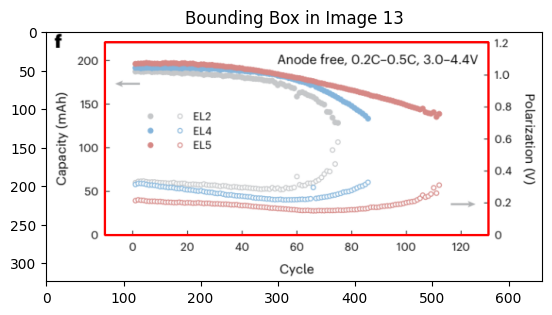

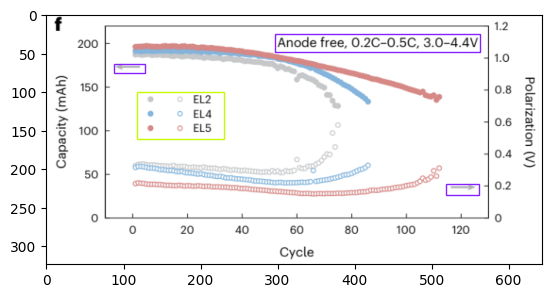

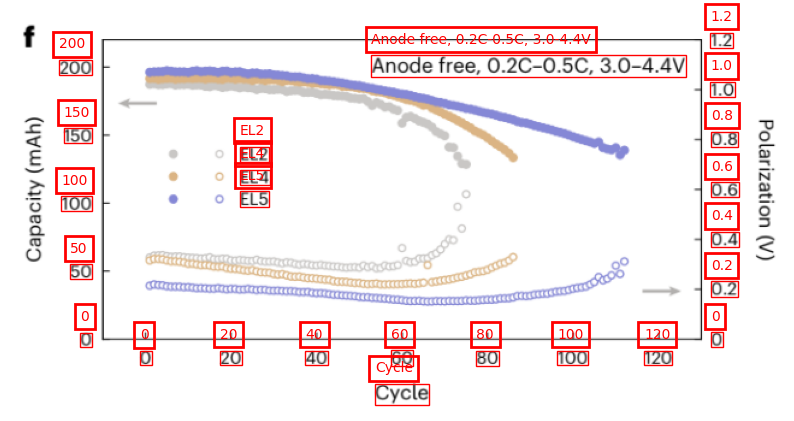

Y MIN 0
Y MAX 200
SEMANTIC Y MIN 0.0
SEMANTIC Y MAX 200.0
Y
OCR DIFF -226.1286244019866
SEM DIFF 200.0
OCR RATIO -1.1306431220099329
PIXEL DIFF 0.3697983920574188
REAL DIFF FROM BASE POINT -0.3270690679124567
Y_MIN 0.3270690679124567
Y_MAX 221.44016402538895
SEMANTIC X MIN 0.0
SEMANTIC X MAX 0.0
X
OCR DIFF 523.985451200977
SEM DIFF 0.0
OCR RATIO 0.0
PIXEL DIFF -13.008792079985142
REAL DIFF FROM BASE POINT -0.0
X_MIN 0.0
X_MAX 0.0
X
Predicted [0.0, 0.0]
Chat GPT [0, 120]
Y
Predicted [0.3270690679124567, 221.44016402538895]
Chat GPT [0, 200]


Attempting to set identical low and high xlims makes transformation singular; automatically expanding.


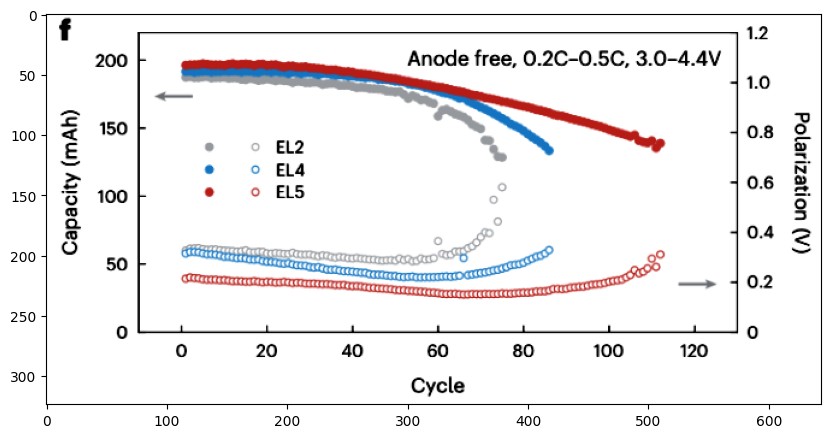

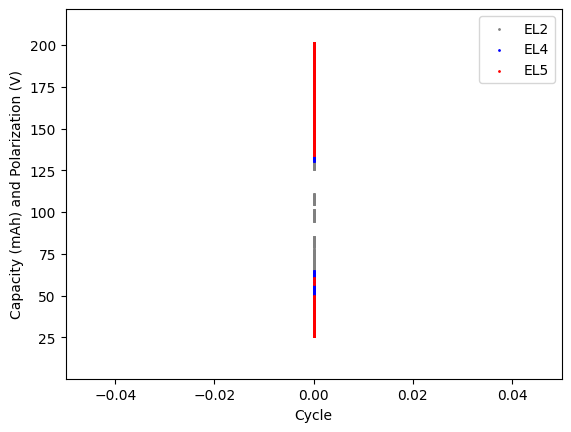

grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
(0.40156862745098043, 0.40156862745098043, 0.40156862745098043)
(0.30117647058823527, 0.30117647058823527, 0.30117647058823527)
(0.20078431372549016, 0.20078431372549016, 0.20078431372549016)
blue
(0.0, 0.0, 1.0)
(0.0, 0.0, 0.8)
red
(1.0, 0.0, 0.0)
(0.8, 0.0, 0.0)
(0.6, 0.0, 0.0)


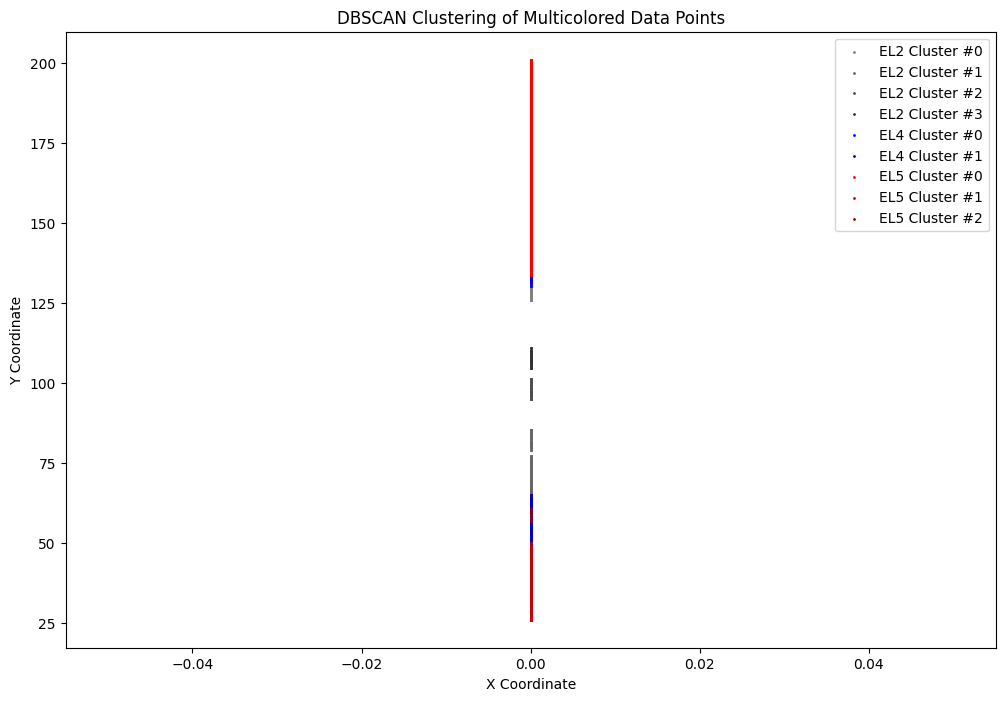

{'topLeft': (69, 17), 'bottomRight': (567, 266)}


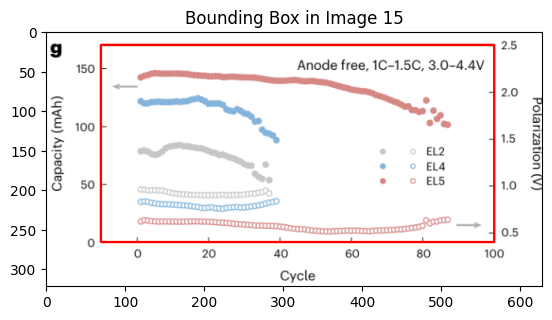

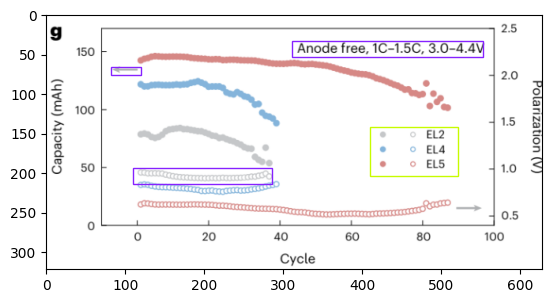

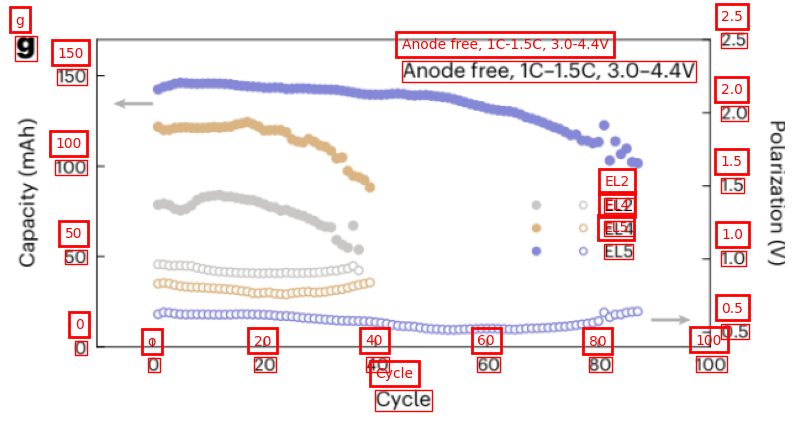

Y MIN 0
Y MAX 150
SEMANTIC Y MIN 0.0
SEMANTIC Y MAX 150.0
Y
OCR DIFF -219.88508423417807
SEM DIFF 150.0
OCR RATIO -1.465900561561187
PIXEL DIFF 1.3731517605483532
REAL DIFF FROM BASE POINT -0.9367291319446278
Y_MIN 0.9367291319446278
Y_MAX 170.7981825819757
SEMANTIC X MIN 0.0
SEMANTIC X MAX 100.0
X
OCR DIFF 510.9125428516418
SEM DIFF 100.0
OCR RATIO 0.19572821493450376
PIXEL DIFF -12.225043604150414
REAL DIFF FROM BASE POINT -2.392785962136833
X_MIN 2.392785962136833
X_MAX 99.8654369995197
X
Predicted [2.392785962136833, 99.8654369995197]
Chat GPT [0, 100]
Y
Predicted [0.9367291319446278, 170.7981825819757]
Chat GPT [0, 150]


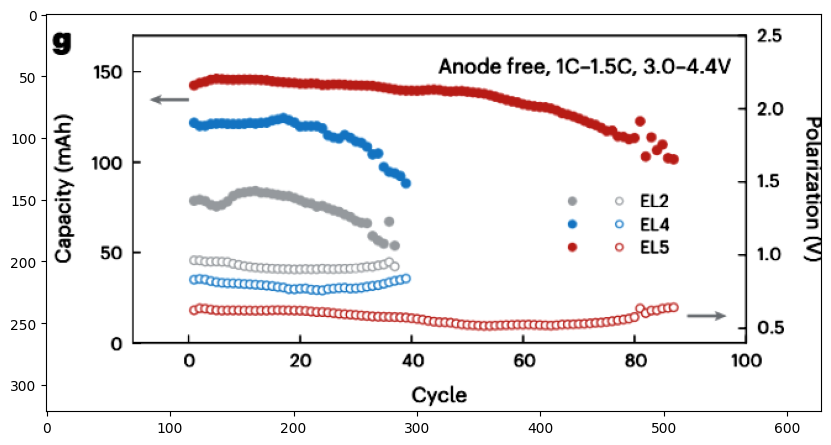

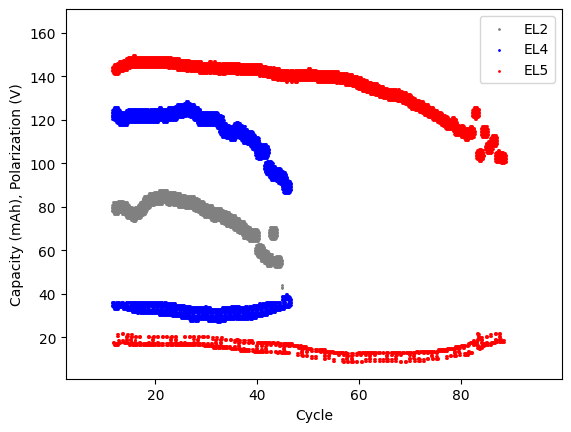

grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
(0.40156862745098043, 0.40156862745098043, 0.40156862745098043)
blue
(0.0, 0.0, 1.0)
(0.0, 0.0, 0.8)
red
(1.0, 0.0, 0.0)
(0.8, 0.0, 0.0)
(0.6, 0.0, 0.0)


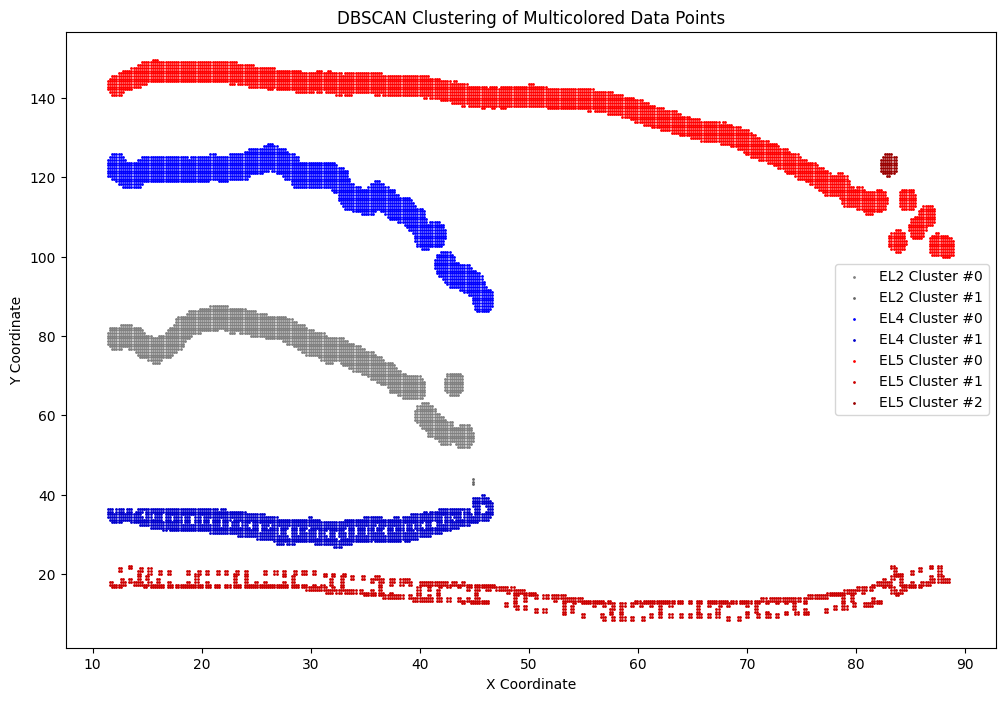

{'topLeft': (80, 32), 'bottomRight': (577, 280)}


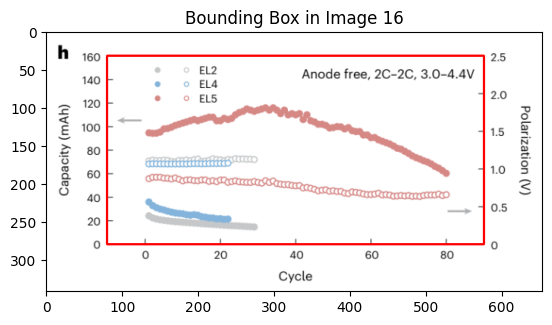

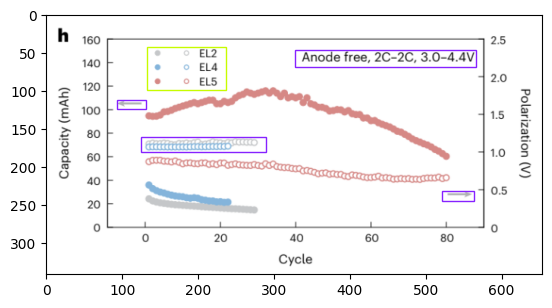

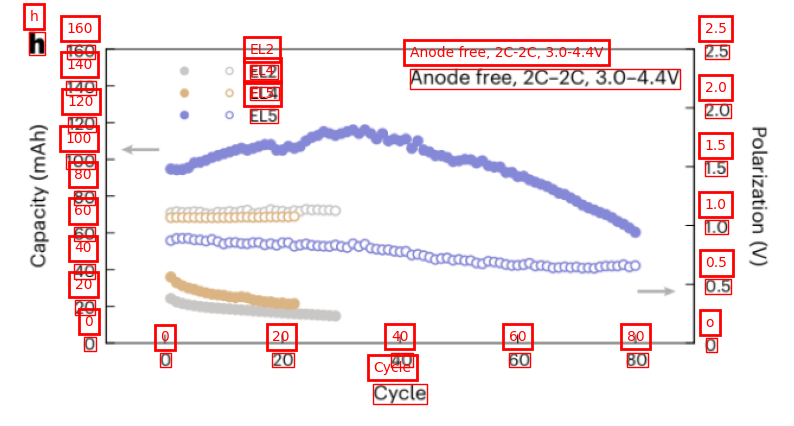

Y MIN 0
Y MAX 160
SEMANTIC Y MIN 0.0
SEMANTIC Y MAX 160.0
Y
OCR DIFF -246.66729724779725
SEM DIFF 160.0
OCR RATIO -1.5416706077987328
PIXEL DIFF 0.7380078732967377
REAL DIFF FROM BASE POINT -0.478706585935694
Y_MIN 0.478706585935694
Y_MAX 161.34316021530447
SEMANTIC X MIN 0.0
SEMANTIC X MAX 80.0
X
OCR DIFF 461.7417592462152
SEM DIFF 80.0
OCR RATIO 0.1732570173652877
PIXEL DIFF -13.080449594184756
REAL DIFF FROM BASE POINT -2.2662796824854388
X_MIN 2.2662796824854388
X_MAX 88.37501731303342
X
Predicted [2.2662796824854388, 88.37501731303342]
Chat GPT [0, 80]
Y
Predicted [0.478706585935694, 161.34316021530447]
Chat GPT [0, 160]


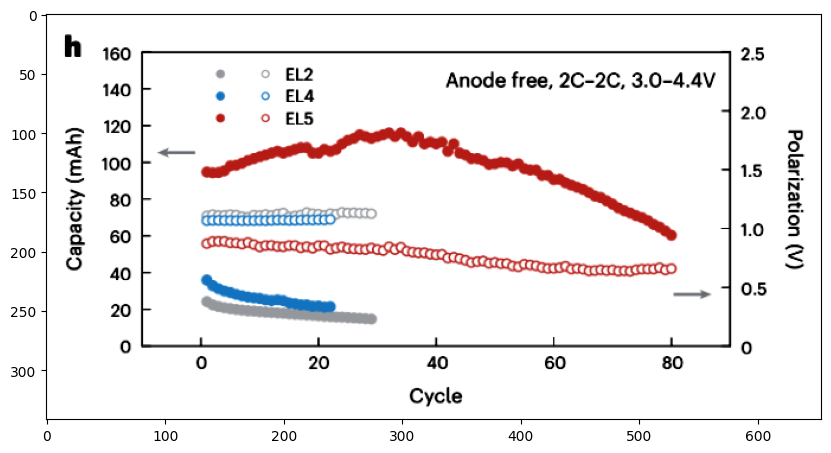

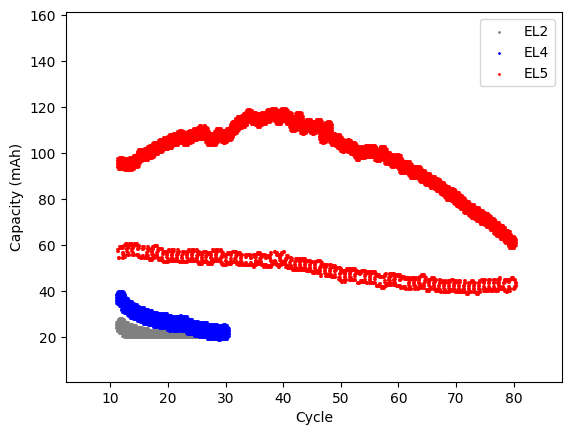

grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
blue
(0.0, 0.0, 1.0)
red
(1.0, 0.0, 0.0)
(0.8, 0.0, 0.0)


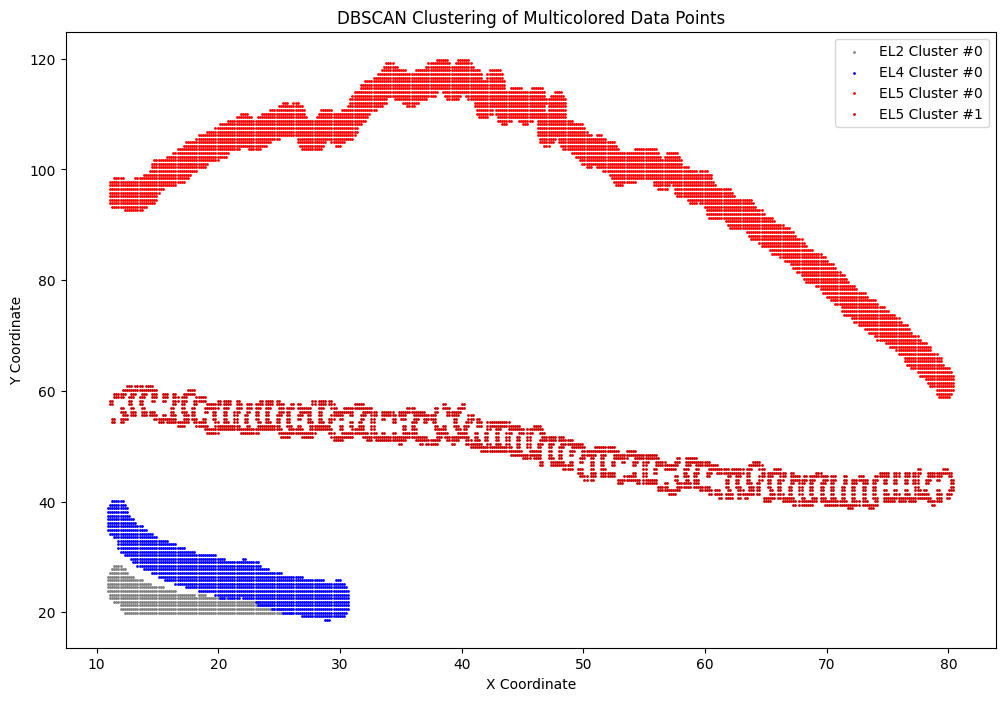

{'topLeft': [87, 26], 'bottomRight': [380, 318]}


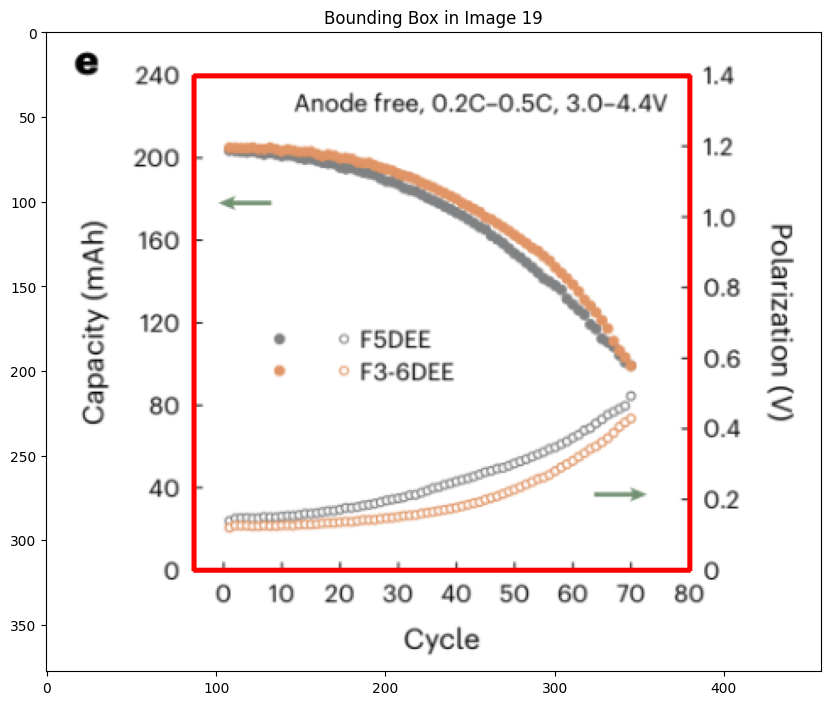

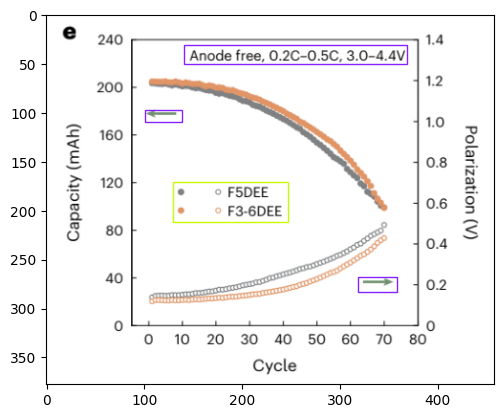

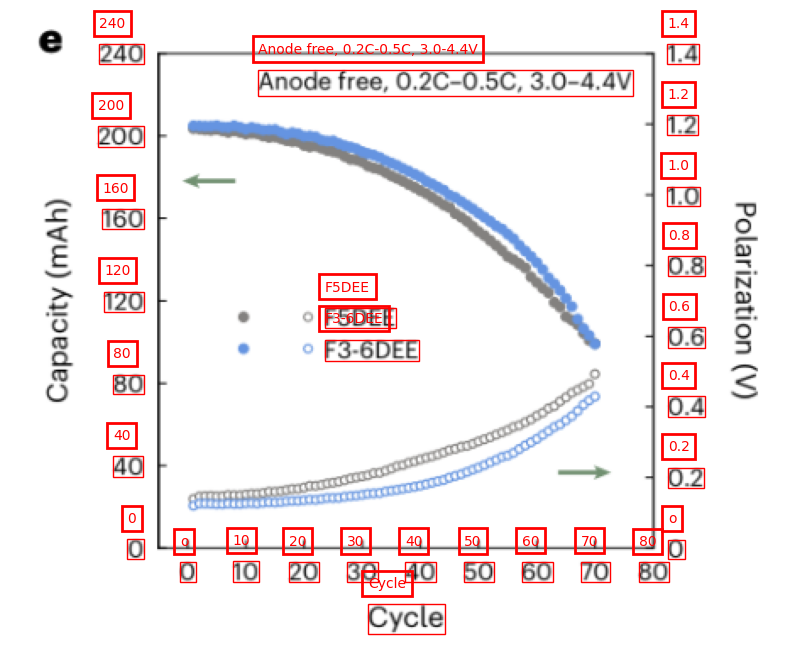

Y MIN 0
Y MAX 240
SEMANTIC Y MIN 0.0
SEMANTIC Y MAX 240.0
Y
OCR DIFF -292.61655566096306
SEM DIFF 240.0
OCR RATIO -1.2192356485873461
PIXEL DIFF 0.5369644537568092
REAL DIFF FROM BASE POINT -0.44041072320921487
Y_MIN 0.44041072320921487
Y_MAX 239.93472040675775
SEMANTIC X MIN 0.0
SEMANTIC X MAX 80.0
X
OCR DIFF 306.0719712153077
SEM DIFF 80.0
OCR RATIO 0.2613764327466746
PIXEL DIFF -13.160181682556868
REAL DIFF FROM BASE POINT -3.4397613424848443
X_MIN 3.4397613424848443
X_MAX 80.0230561372605
X
Predicted [3.4397613424848443, 80.0230561372605]
Chat GPT [0, 80]
Y
Predicted [0.44041072320921487, 239.93472040675775]
Chat GPT [0, 240]


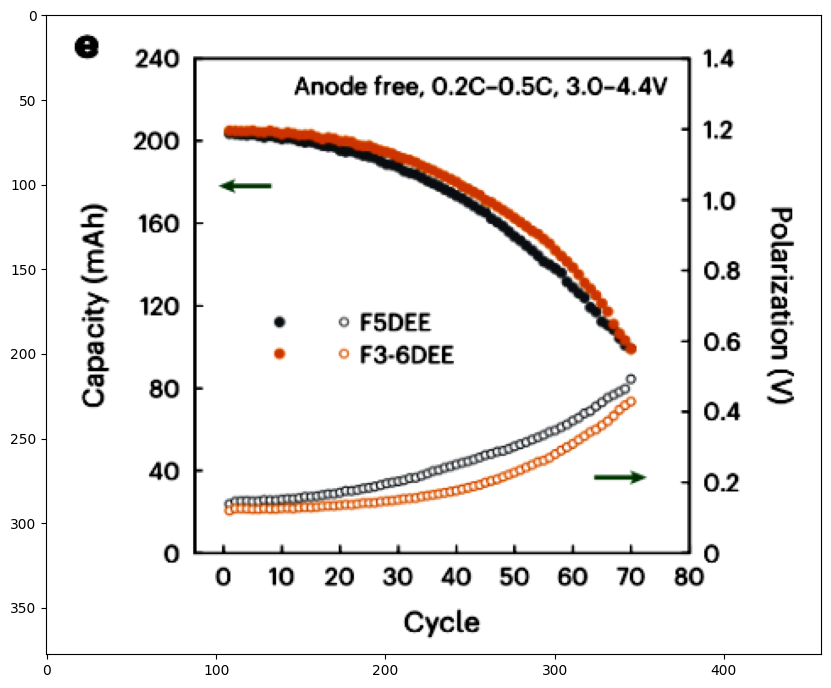

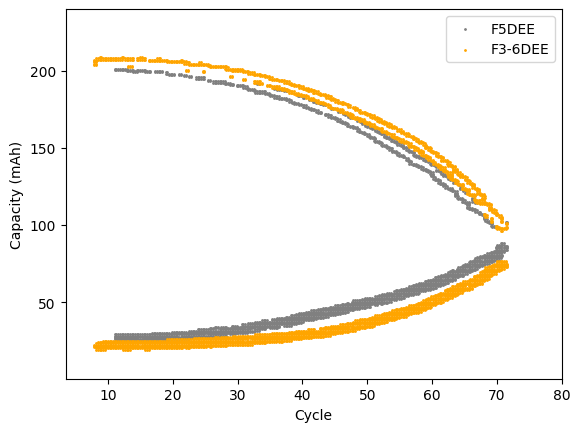

grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
(0.40156862745098043, 0.40156862745098043, 0.40156862745098043)
orange
(1.0, 0.6470588235294118, 0.0)
(0.8, 0.5176470588235295, 0.0)
(0.6, 0.3882352941176471, 0.0)


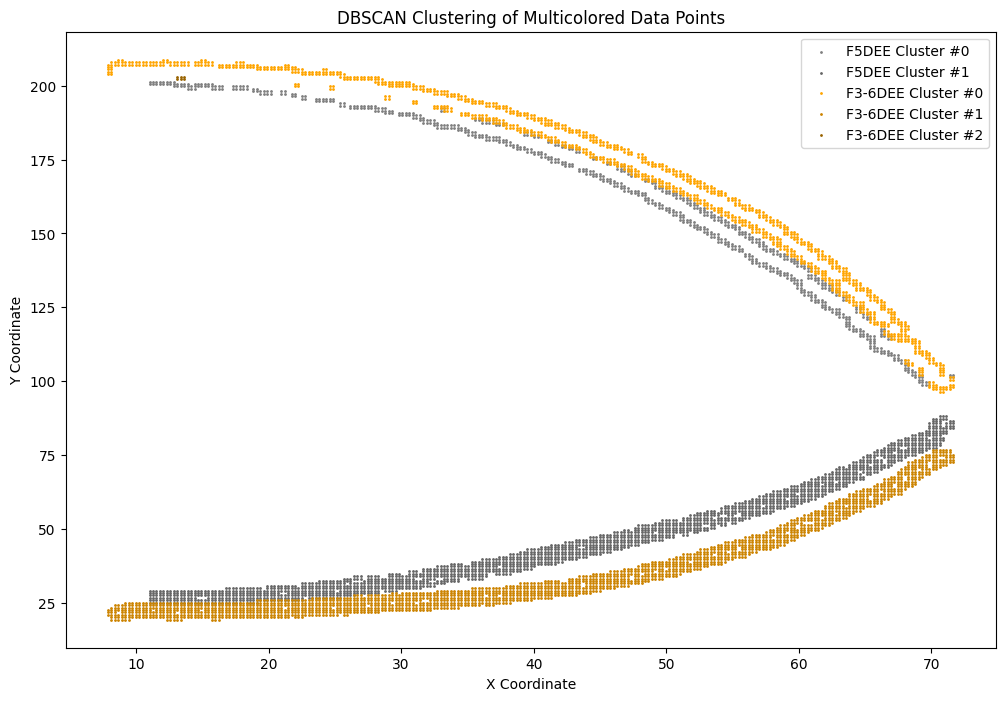

{'topLeft': (79, 29), 'bottomRight': (372, 322)}


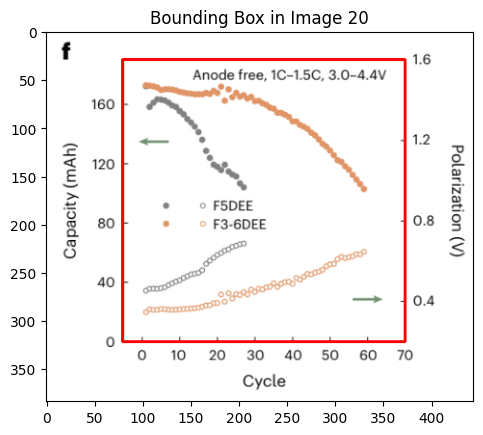

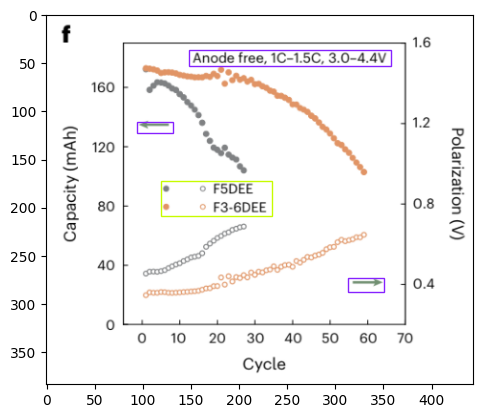

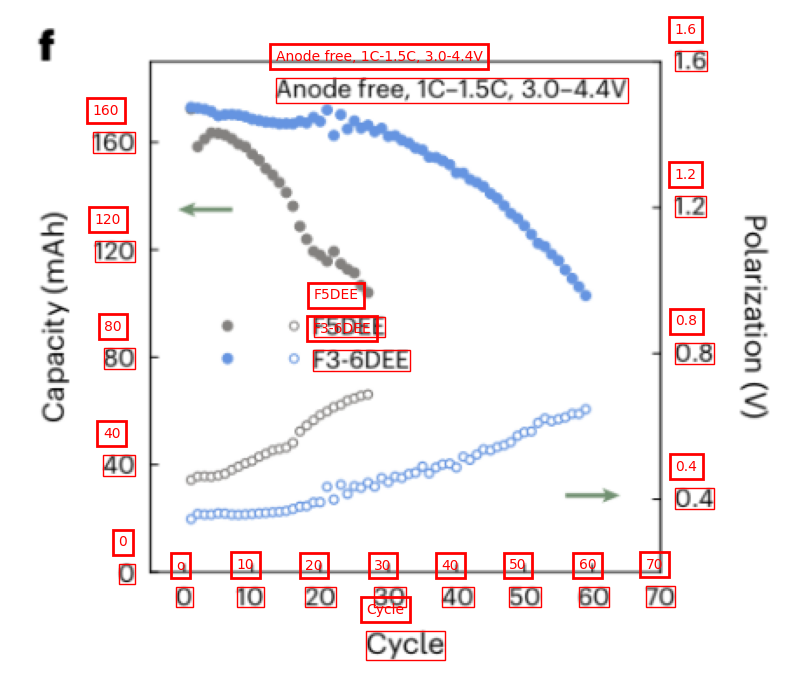

Y MIN 0
Y MAX 160
SEMANTIC Y MIN 0.0
SEMANTIC Y MAX 160.0
Y
OCR DIFF -246.83155810832977
SEM DIFF 160.0
OCR RATIO -1.5426972381770612
PIXEL DIFF 0.6316367387771606
REAL DIFF FROM BASE POINT -0.4094366173388231
Y_MIN 0.4094366173388231
Y_MAX 190.33652843363421
SEMANTIC X MIN 0.0
SEMANTIC X MAX 70.0
X
OCR DIFF 305.58698357641697
SEM DIFF 70.0
OCR RATIO 0.22906734829068845
PIXEL DIFF -12.500037156045437
REAL DIFF FROM BASE POINT -2.863350364870407
X_MIN 2.863350364870407
X_MAX 69.98008341404213
X
Predicted [2.863350364870407, 69.98008341404213]
Chat GPT [0, 70]
Y
Predicted [0.4094366173388231, 190.33652843363421]
Chat GPT [0, 160]


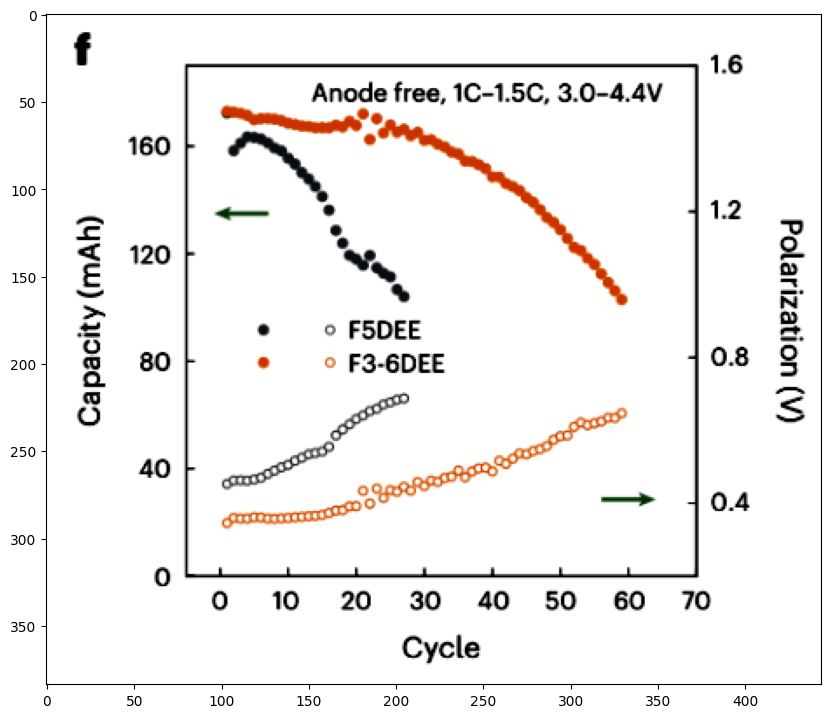

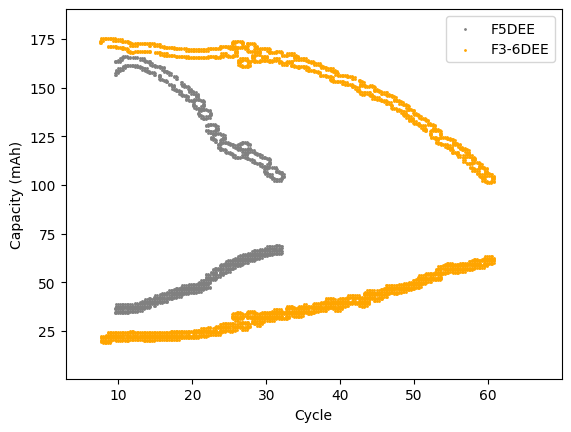

grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
(0.40156862745098043, 0.40156862745098043, 0.40156862745098043)
orange
(1.0, 0.6470588235294118, 0.0)
(0.8, 0.5176470588235295, 0.0)


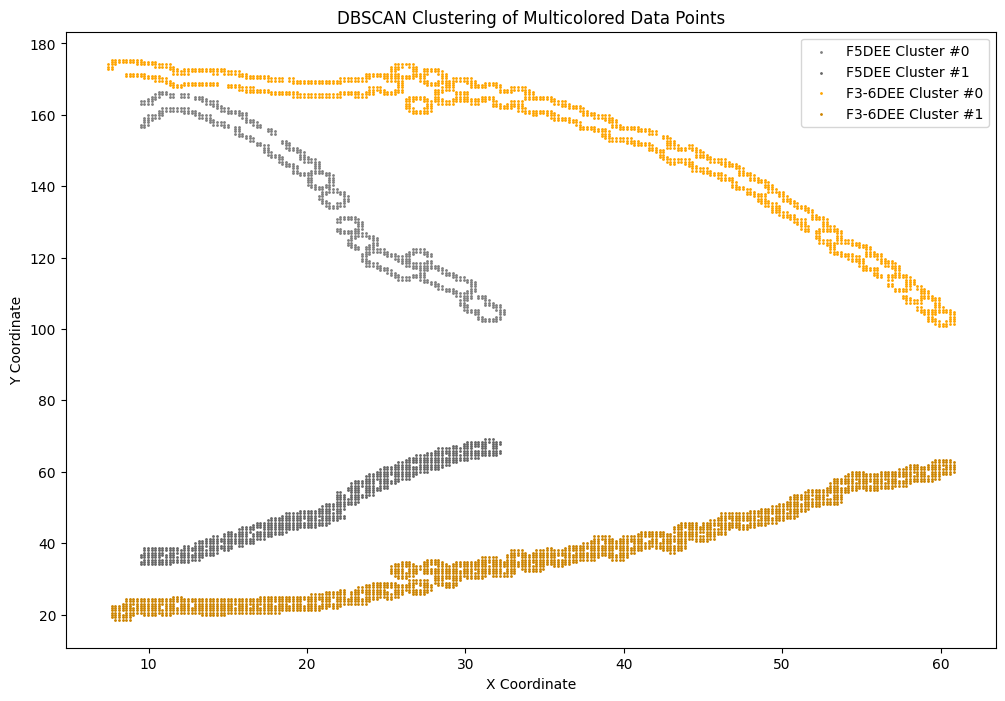

{'topLeft': [84, 30], 'bottomRight': [377, 322]}


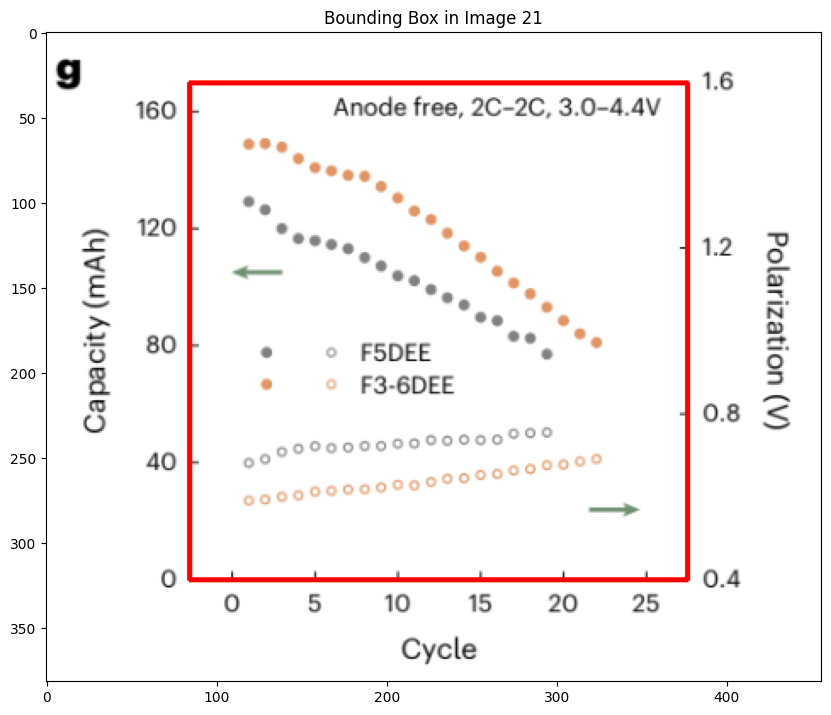

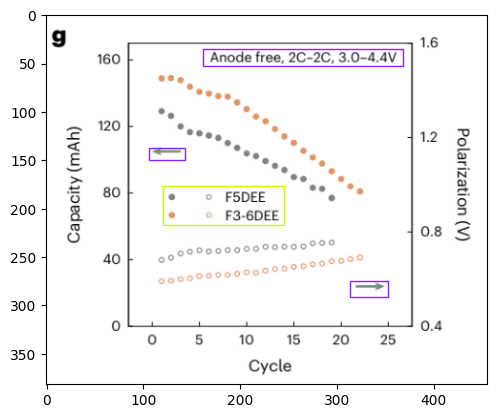

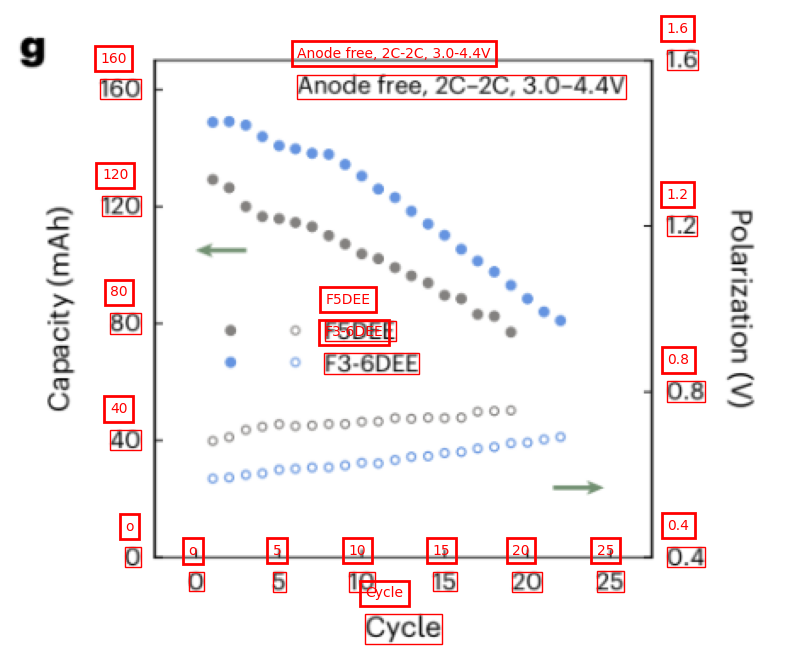

Y MIN 40
Y MAX 160
SEMANTIC Y MIN 40.0
SEMANTIC Y MAX 160.0
Y
OCR DIFF -206.42152911238372
SEM DIFF 120.0
OCR RATIO -1.7201794092698643
PIXEL DIFF -69.26556494086981
REAL DIFF FROM BASE POINT 40.2664771869754
Y_MIN -0.26647718697540057
Y_MAX 169.4832584664355
SEMANTIC X MIN 5.0
SEMANTIC X MAX 25.0
X
OCR DIFF 194.71473714709282
SEM DIFF 20.0
OCR RATIO 0.10271436200995641
PIXEL DIFF 73.97851900756359
REAL DIFF FROM BASE POINT 7.598656382303329
X_MIN -2.5986563823033286
X_MAX 27.4966516866139
X
Predicted [-2.5986563823033286, 27.4966516866139]
Chat GPT [0, 25]
Y
Predicted [-0.26647718697540057, 169.4832584664355]
Chat GPT [40, 160]


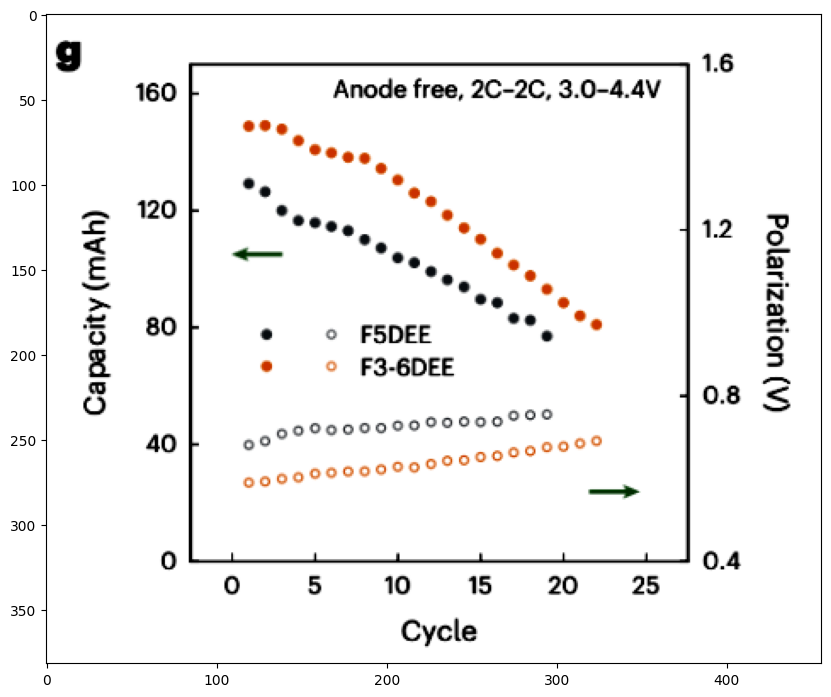

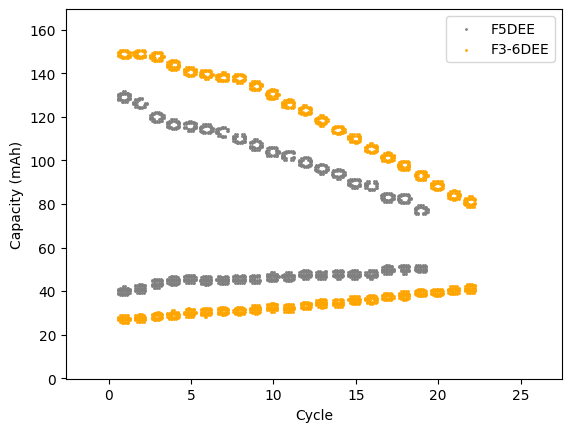

grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
(0.40156862745098043, 0.40156862745098043, 0.40156862745098043)
orange
(1.0, 0.6470588235294118, 0.0)
(0.8, 0.5176470588235295, 0.0)


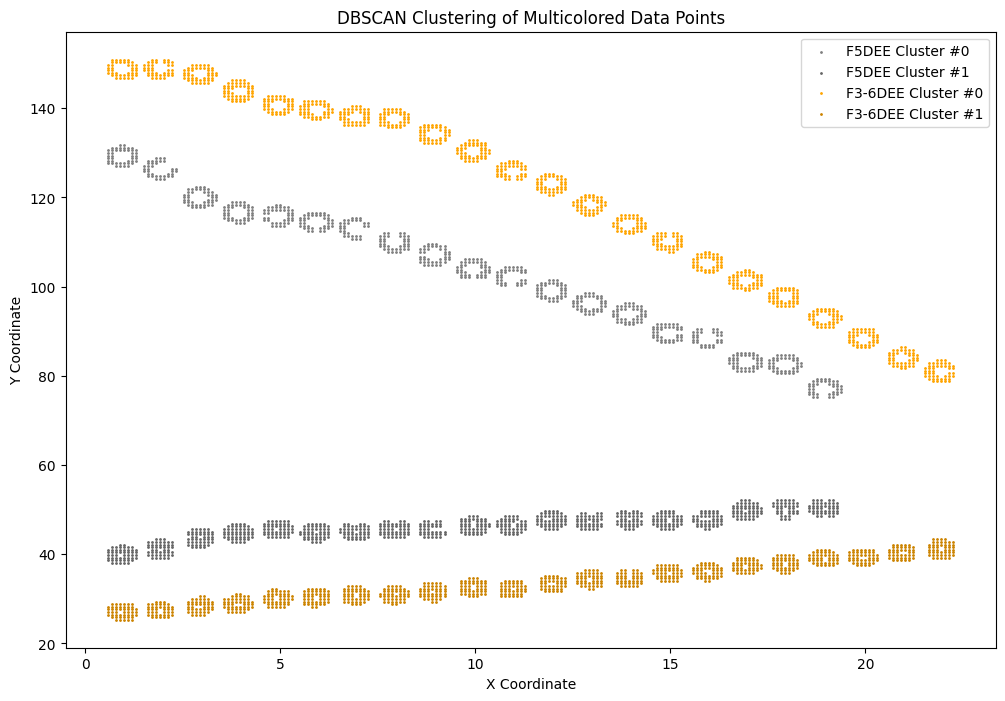

{'topLeft': (175, 28), 'bottomRight': (1219, 549)}


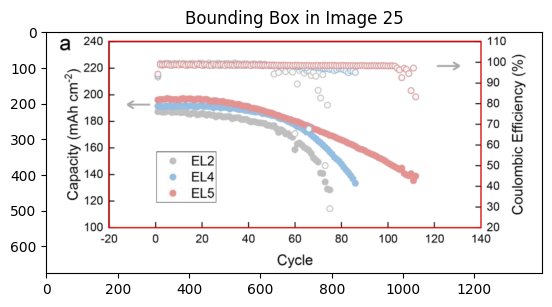

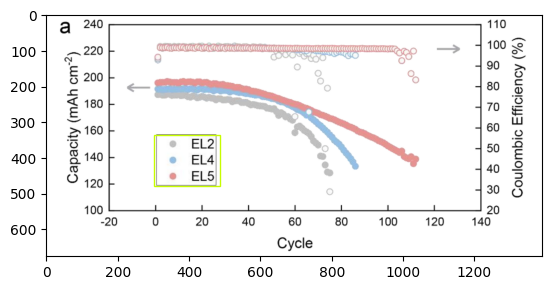

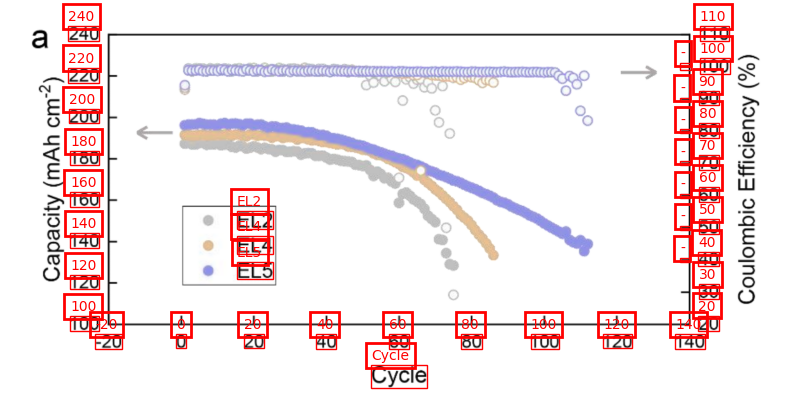

Y MIN 100
Y MAX 240
SEMANTIC Y MIN 100.0
SEMANTIC Y MAX 240.0
Y
OCR DIFF -519.5225781053305
SEM DIFF 140.0
OCR RATIO -3.7108755578952177
PIXEL DIFF -2.300386890769005
REAL DIFF FROM BASE POINT 0.619904077859665
Y_MIN 99.38009592214034
Y_MAX 239.77822888877301
SEMANTIC X MIN -20.0
SEMANTIC X MAX 140.0
X
OCR DIFF 1043.5642710700631
SEM DIFF 160.0
OCR RATIO 0.15332069565388357
PIXEL DIFF 1.061048749834299
REAL DIFF FROM BASE POINT 0.1626807324472782
X_MIN -20.162680732447278
X_MAX 139.90412553020715
X
Predicted [-20.162680732447278, 139.90412553020715]
Chat GPT [-20, 140]
Y
Predicted [99.38009592214034, 239.77822888877301]
Chat GPT [100, 240]


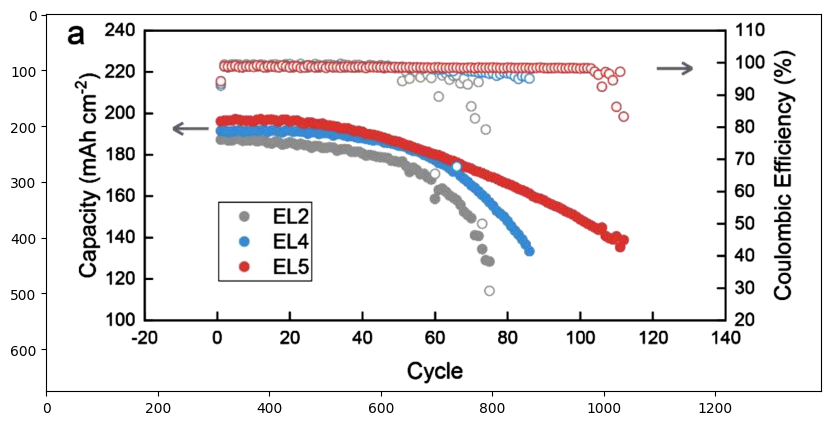

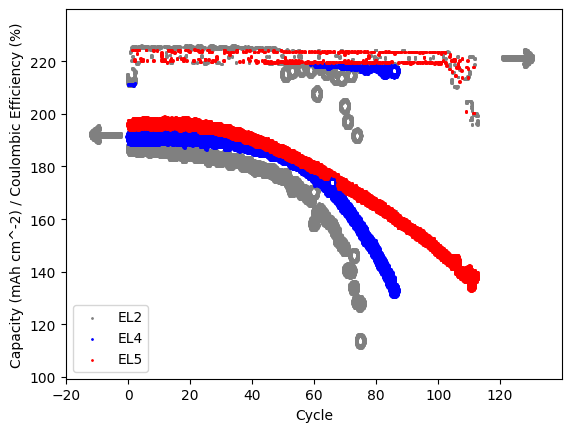

grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
(0.40156862745098043, 0.40156862745098043, 0.40156862745098043)
(0.30117647058823527, 0.30117647058823527, 0.30117647058823527)
(0.20078431372549016, 0.20078431372549016, 0.20078431372549016)
(0.10039215686274508, 0.10039215686274508, 0.10039215686274508)
(0.0, 0.0, 0.0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
blue
(0.0, 0.0, 1.0)
(0.0, 0.0, 0.8)
(0.0, 0.0, 0.6)
red
(1.0, 0.0, 0.0)
(0.8, 0.0, 0.0)
(0.6, 0.0, 0.0)


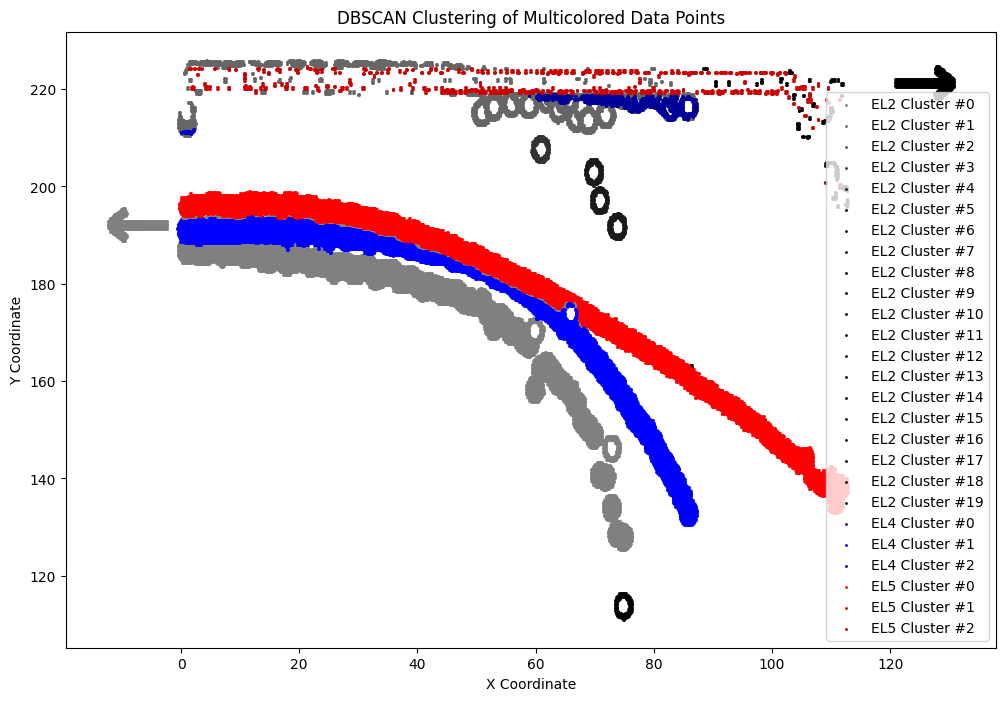

{'topLeft': (169, 39), 'bottomRight': (1211, 560)}


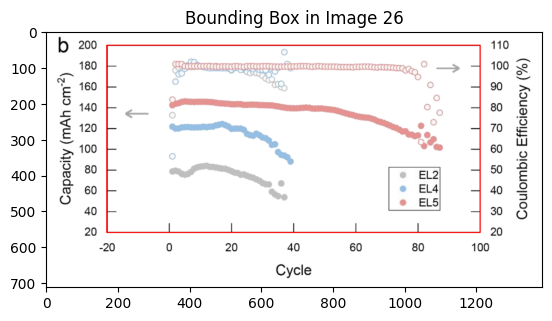

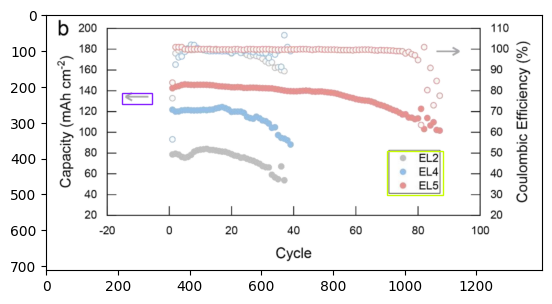

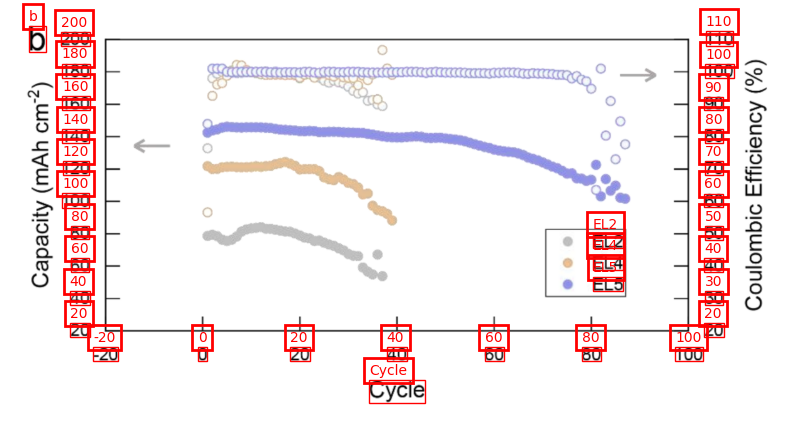

Y MIN 20
Y MAX 200
SEMANTIC Y MIN 20.0
SEMANTIC Y MAX 200.0
Y
OCR DIFF -519.6121896505356
SEM DIFF 180.0
OCR RATIO -2.88673438694742
PIXEL DIFF -2.3739048838615417
REAL DIFF FROM BASE POINT 0.8223496053517517
Y_MIN 19.17765039464825
Y_MAX 199.6584048262785
SEMANTIC X MIN -20.0
SEMANTIC X MAX 100.0
X
OCR DIFF 1041.8924627751112
SEM DIFF 120.0
OCR RATIO 0.11517503416847501
PIXEL DIFF 1.201727256178856
REAL DIFF FROM BASE POINT 0.13840897779158745
X_MIN -20.13840897779159
X_MAX 99.87397662575937
X
Predicted [-20.13840897779159, 99.87397662575937]
Chat GPT [-20, 100]
Y
Predicted [19.17765039464825, 199.6584048262785]
Chat GPT [20, 200]


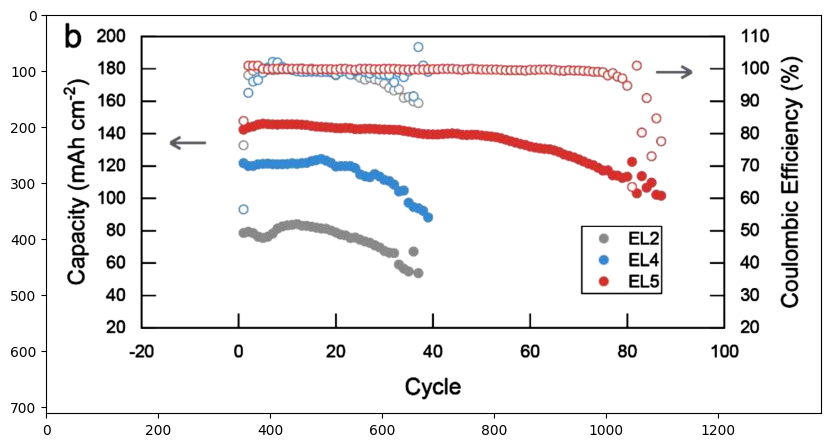

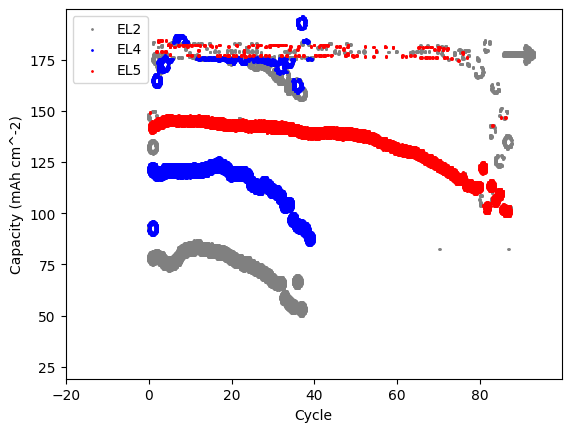

grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
(0.40156862745098043, 0.40156862745098043, 0.40156862745098043)
(0.30117647058823527, 0.30117647058823527, 0.30117647058823527)
(0.20078431372549016, 0.20078431372549016, 0.20078431372549016)
(0.10039215686274508, 0.10039215686274508, 0.10039215686274508)
(0.0, 0.0, 0.0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
blue
(0.0, 0.0, 1.0)
(0.0, 0.0, 0.8)
(0.0, 0.0, 0.6)
(0.0, 0.0, 0.3999999999999999)
(0.0, 0.0, 0.19999999999999996)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
red
(1.0, 0.0, 0.0)
(0.8, 0.0, 0.0)
(0.6, 0.0, 0.0)
(0.3999999999999999, 0.0, 0.0)
(0.19999999999999996, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)


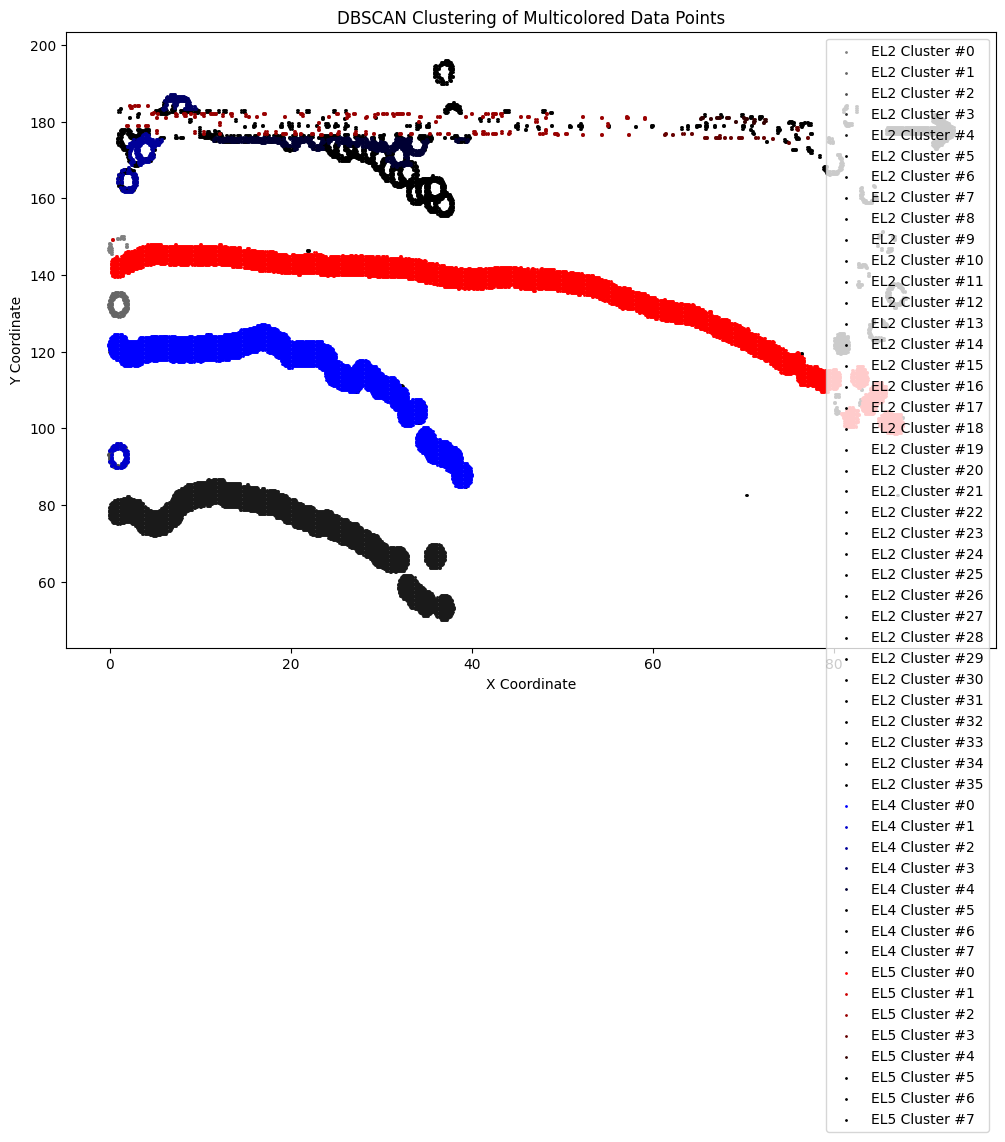

{'topLeft': (171, 39), 'bottomRight': (1215, 561)}


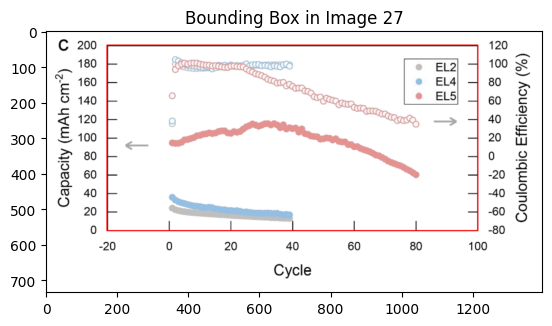

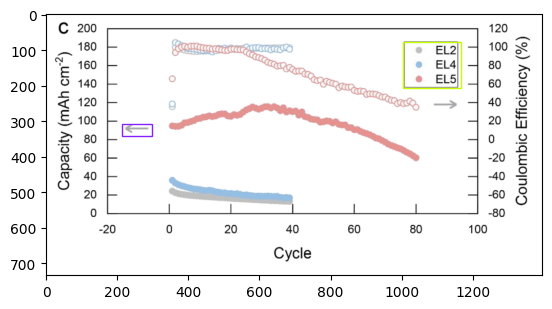

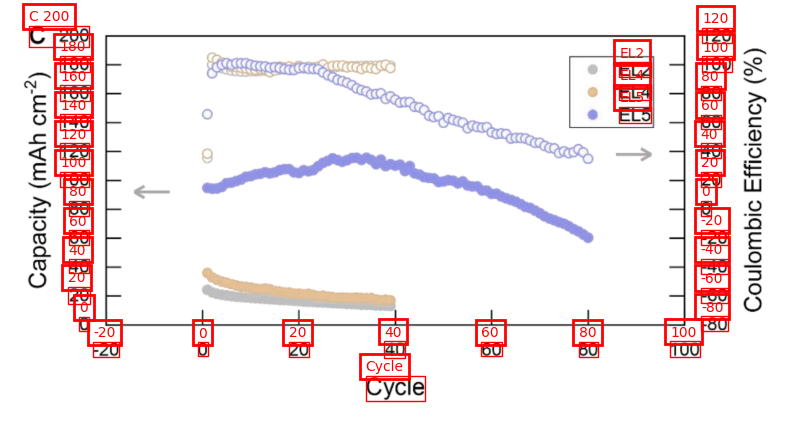

Y MIN 0
Y MAX 180
SEMANTIC Y MIN 0.0
SEMANTIC Y MAX 180.0
Y
OCR DIFF -467.96967074275017
SEM DIFF 180.0
OCR RATIO -2.59983150412639
PIXEL DIFF -2.440985720604658
REAL DIFF FROM BASE POINT 0.9389015083209755
Y_MIN -0.9389015083209755
Y_MAX 199.84334117605843
SEMANTIC X MIN -20.0
SEMANTIC X MAX 100.0
X
OCR DIFF 1042.8252710029483
SEM DIFF 120.0
OCR RATIO 0.11507200998743417
PIXEL DIFF 1.8106782734394073
REAL DIFF FROM BASE POINT 0.20835838836524953
X_MIN -20.208358388365248
X_MAX 99.92682003851601
X
Predicted [-20.208358388365248, 99.92682003851601]
Chat GPT [-20, 100]
Y
Predicted [-0.9389015083209755, 199.84334117605843]
Chat GPT [0, 200]


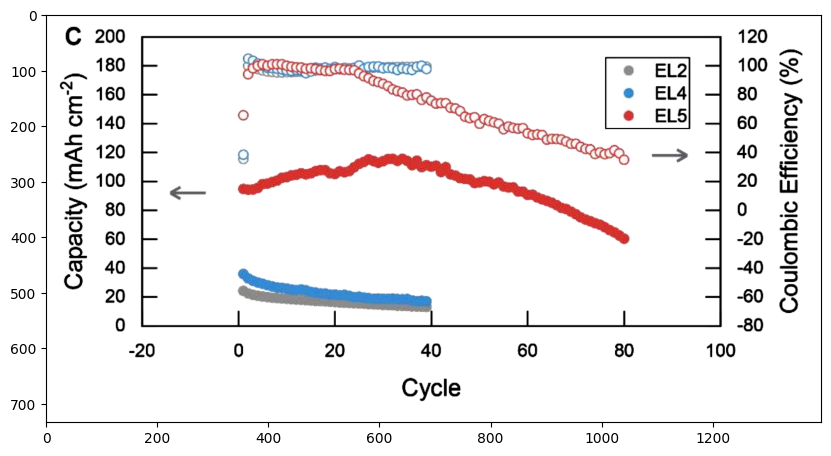

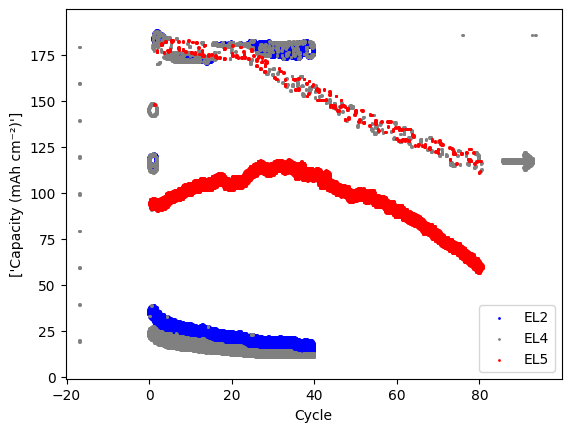

blue
(0.0, 0.0, 1.0)
(0.0, 0.0, 0.8)
(0.0, 0.0, 0.6)
(0.0, 0.0, 0.3999999999999999)
(0.0, 0.0, 0.19999999999999996)
grey
(0.5019607843137255, 0.5019607843137255, 0.5019607843137255)
(0.40156862745098043, 0.40156862745098043, 0.40156862745098043)
(0.30117647058823527, 0.30117647058823527, 0.30117647058823527)
(0.20078431372549016, 0.20078431372549016, 0.20078431372549016)
(0.10039215686274508, 0.10039215686274508, 0.10039215686274508)
(0.0, 0.0, 0.0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
red
(1.0, 0.0, 0.0)
(0.8, 0.0, 0.0)
(0.6, 0.0, 0.0)
(0.3999999999999999, 0.0, 0.0)
(0.19999999999999996, 0.0, 0.0)
(0.0, 0.0, 0.0)


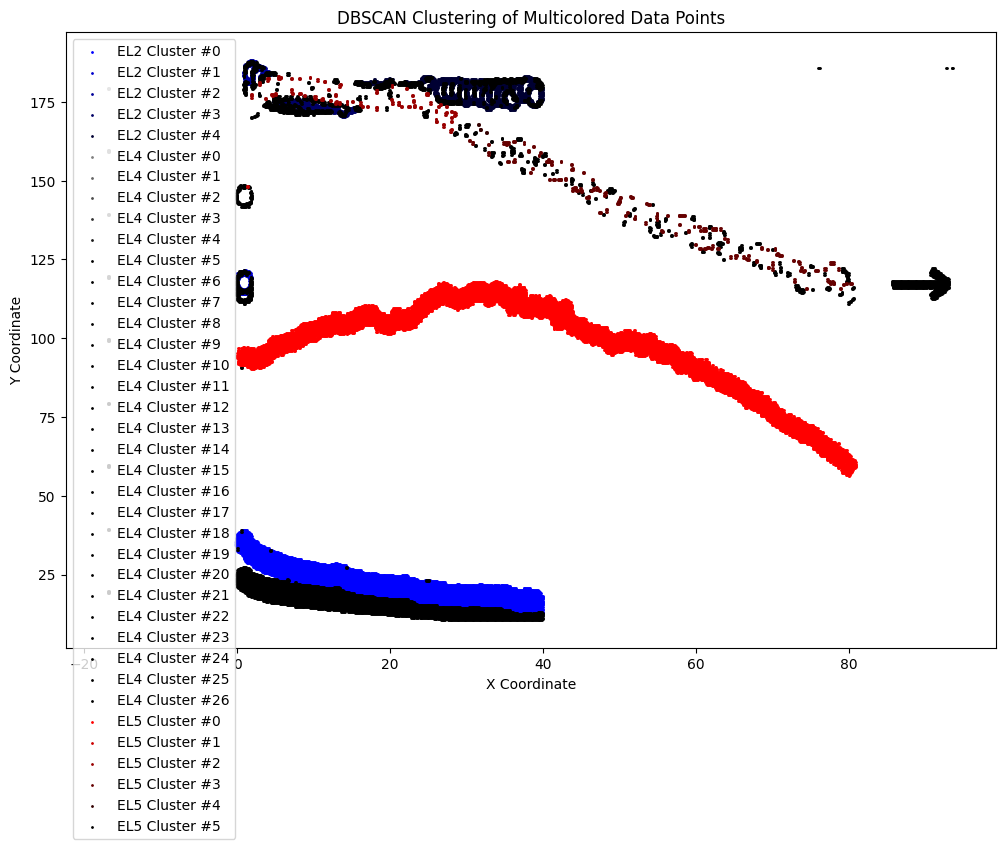

{'topLeft': (133, 30), 'bottomRight': (1388, 523)}


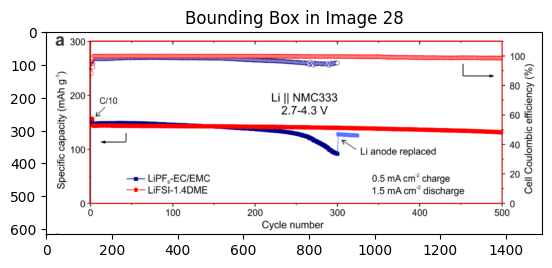

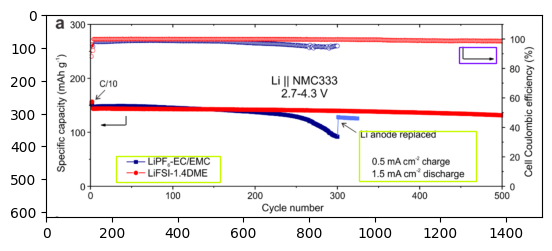

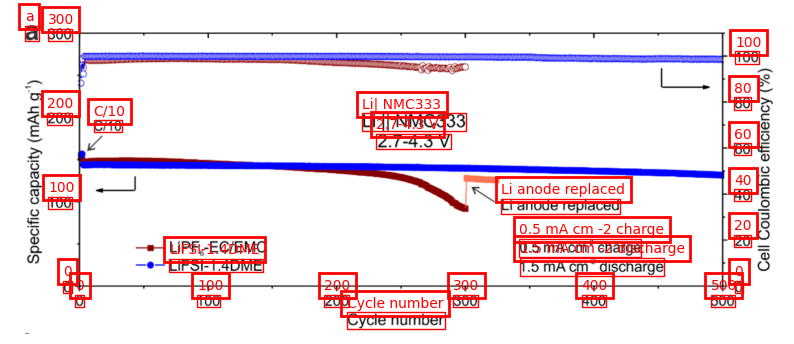

Y MIN 0
Y MAX 300
SEMANTIC Y MIN 0.0
SEMANTIC Y MAX 300.0
Y
OCR DIFF -491.64411003887653
SEM DIFF 300.0
OCR RATIO -1.6388137001295884
PIXEL DIFF 0.9052019119262695
REAL DIFF FROM BASE POINT -0.552351931067388
Y_MIN 0.552351931067388
Y_MAX 301.3797125767688
SEMANTIC X MIN 0.0
SEMANTIC X MAX 500.0
X
OCR DIFF 1253.0580368544906
SEM DIFF 500.0
OCR RATIO 0.39902381637097445
PIXEL DIFF 2.0019089225679636
REAL DIFF FROM BASE POINT 0.7988093383101744
X_MIN -0.7988093383101744
X_MAX 499.9760802072628
X
Predicted [-0.7988093383101744, 499.9760802072628]
Chat GPT [0, 500]
Y
Predicted [0.552351931067388, 301.3797125767688]
Chat GPT [0, 300]


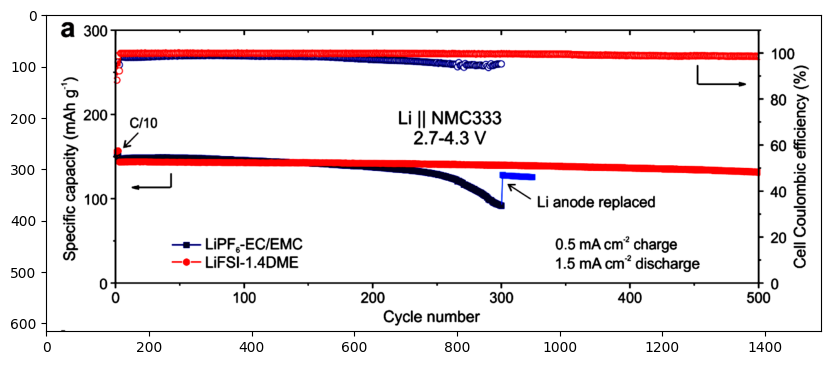

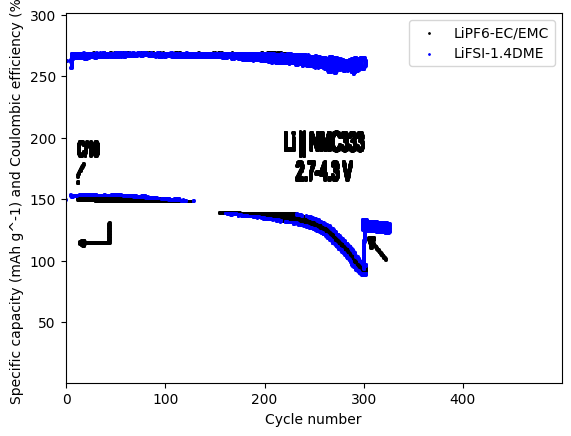

black
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
(-0.0, -0.0, -0.0)
blue
(0.0, 0.0, 1.0)
(0.0, 0.0, 0.8)
(0.0, 0.0, 0.6)
(0.0, 0.0, 0.3999999999999999)
(0.0, 0.0, 0.19999999999999996)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)


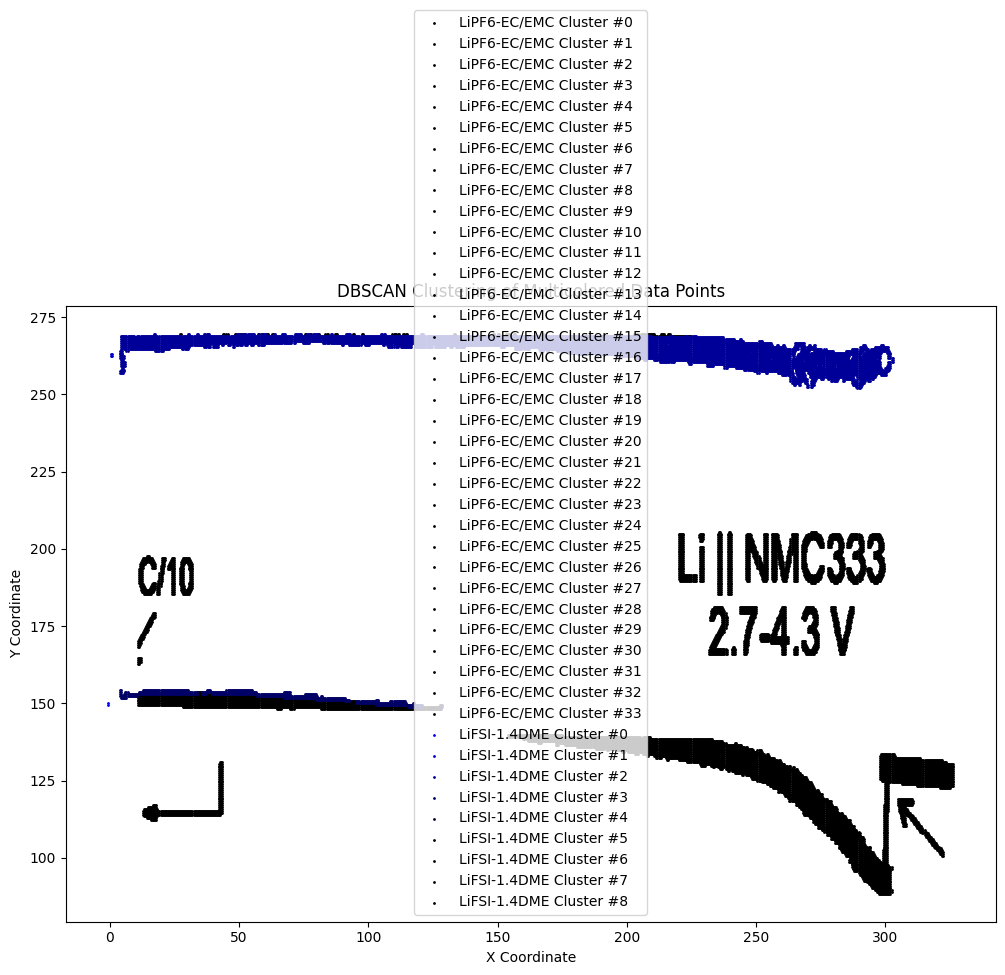

In [17]:
for image_num in range(1, 29):
    if second_axis[image_num]:
        coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = get_reconstructed_plot(image_num, predictor, model, True, 30)
        
        plt.figure()
        for index, value in enumerate(coordinates):
            x = []
            y = []

            for i in range(len(value)):
                x.append(value[i]["middle"][0])
                y.append(value[i]["middle"][1])

            color_normalized = rgb_colors[index]

            if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

        plt.xlim(x_range[0], x_range[1])
        plt.ylim(y_range[0], y_range[1])
        plt.xlabel(x_axis_title)
        plt.ylabel(y_axis_title)
        plt.legend()
        plt.show()

        if second_axis[image_num]:
            try:
                second_axis_clustering(rgb_colors, coordinates, axis_labels)
            except:
                print("ERROR CLUSTERING IMAGE", image_num)